# Statistics and Visualisations

In [1]:
from tools import load_settings
settings = load_settings()
NAME = settings["NAME"]

In [2]:
import pickle
import pandas as pd
from eventstudystatistics import grank, adjBMP
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
# set logging to warning
import logging
logging.getLogger().setLevel(logging.WARNING)
# unpickle the abnormal returns
df_abnormal_returns = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_abnormal_returns.pkl")

# set plotting sizes
tick_size = 15
label_size = 20
title_size = 30
fig_height = 20

EVENT_INDEX = 20 # because 20 [0,..19] are before the event

investigation_periods = {
    "Overall": (pd.Timestamp("2018-01-01"), pd.Timestamp("2021-12-31")),
    "Pre-Pandemic": (pd.Timestamp("2018-01-01"), pd.Timestamp("2020-02-29")),
    "Pandemic": (pd.Timestamp("2020-03-01"), pd.Timestamp("2021-12-31")),
}


CAR_repr = lambda x: str([x[0]-20, x[1]-20])
CAR_periods = {
    "[-20, 20]": np.asarray([0, 40]), # Aussenegg advised to drop this
    "[-20, -1]": np.asarray([0, 19]),
    "[0, 20]": np.asarray([20, 40]),
    "[0, 5]": np.asarray([20, 25]),
    "[0, 1]": np.asarray([20, 21])
}
event_day = 20

with open(f"data/{NAME}/calculate_AR_results/companies.pkl", "rb") as f:
    companies = pickle.load(f)


DEBUG:matplotlib:matplotlib data path: C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\matplotlib\mpl-data
DEBUG:matplotlib:CONFIGDIR=C:\Users\waxfa\.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is win32
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', '_io', 'marshal', 'nt', 'winreg', '_frozen_importlib_external', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', 'encodings.cp1252', '_signal', 'encodings.latin_1', '_abc', 'abc', 'io', '__main__', '_stat', 'stat', '_collections_abc', 'genericpath', 'ntpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', '_heapq', 'heapq', 'itertools', 'keyword', '_operator', 'operator', 'reprlib', '_collections', 'collections', 'collections.abc', '_functools', 'functools', 'contex

### Having a look at all trade types together

In [3]:
types_of_interest = ["P - Purchase", "S - Sale", "S - Sale+OE"]
counts = df_abnormal_returns.groupby(level=2).count()[0].rename({0: "N"})
print(f"relevant filings: ",counts[types_of_interest].sum())
print(counts[types_of_interest])
print(f"dropped filings ", counts.sum() - counts[types_of_interest].sum())

relevant filings:  107558
TradeType
P - Purchase    25030
S - Sale        49043
S - Sale+OE     33485
Name: 0, dtype: int64
dropped filings  210488


In [4]:
# enable multiindex slicing
df_abnormal_returns.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)

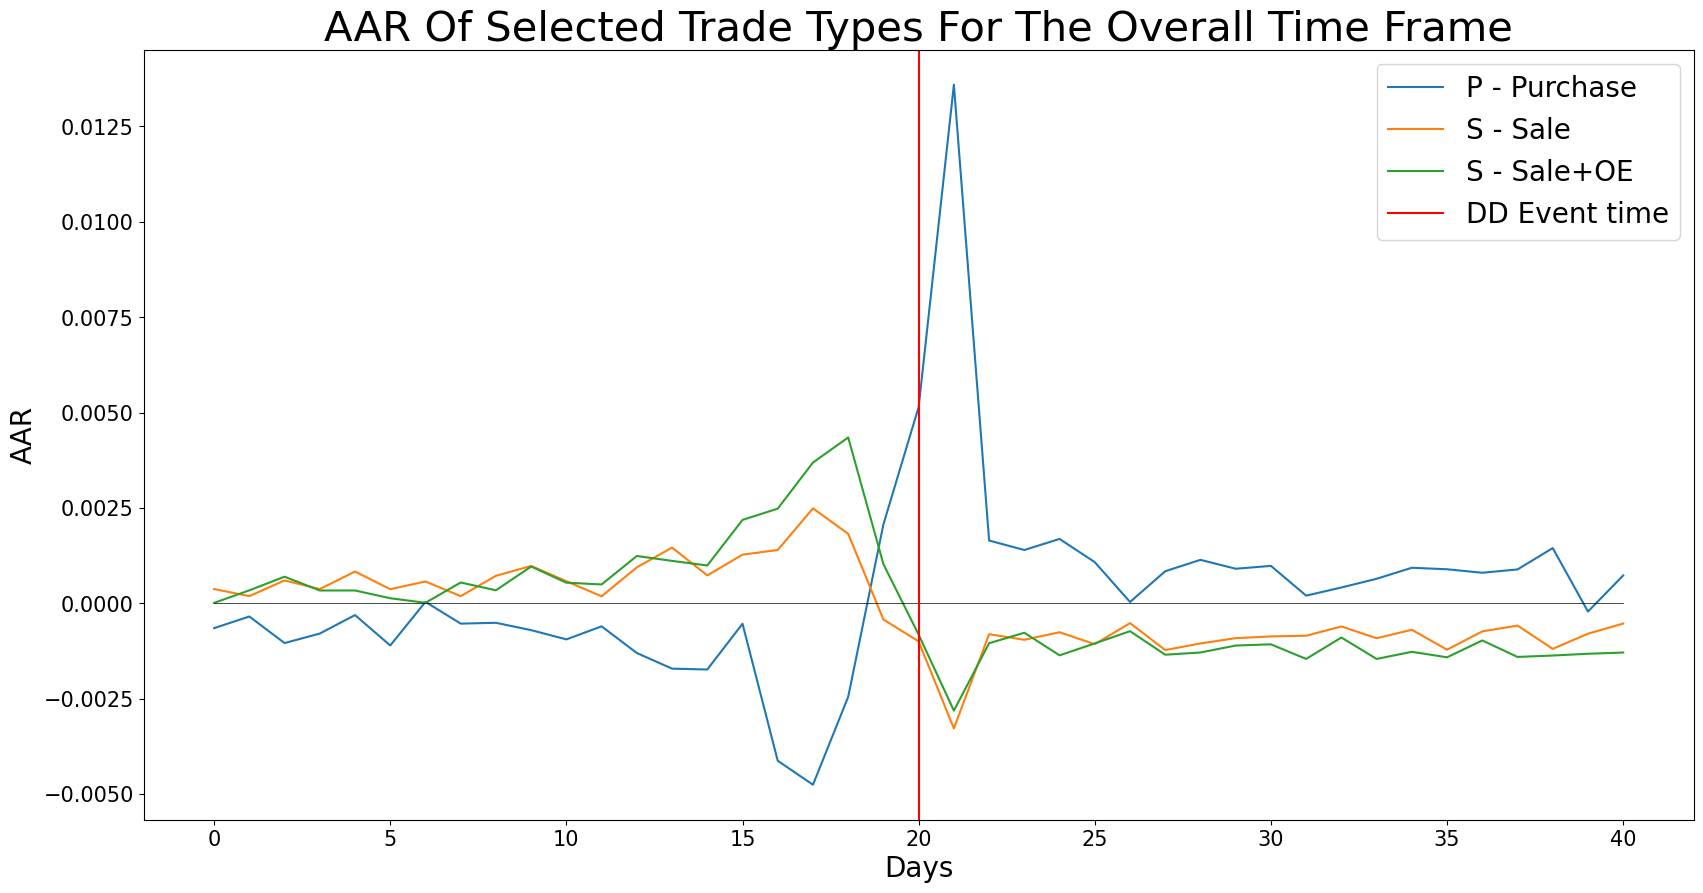

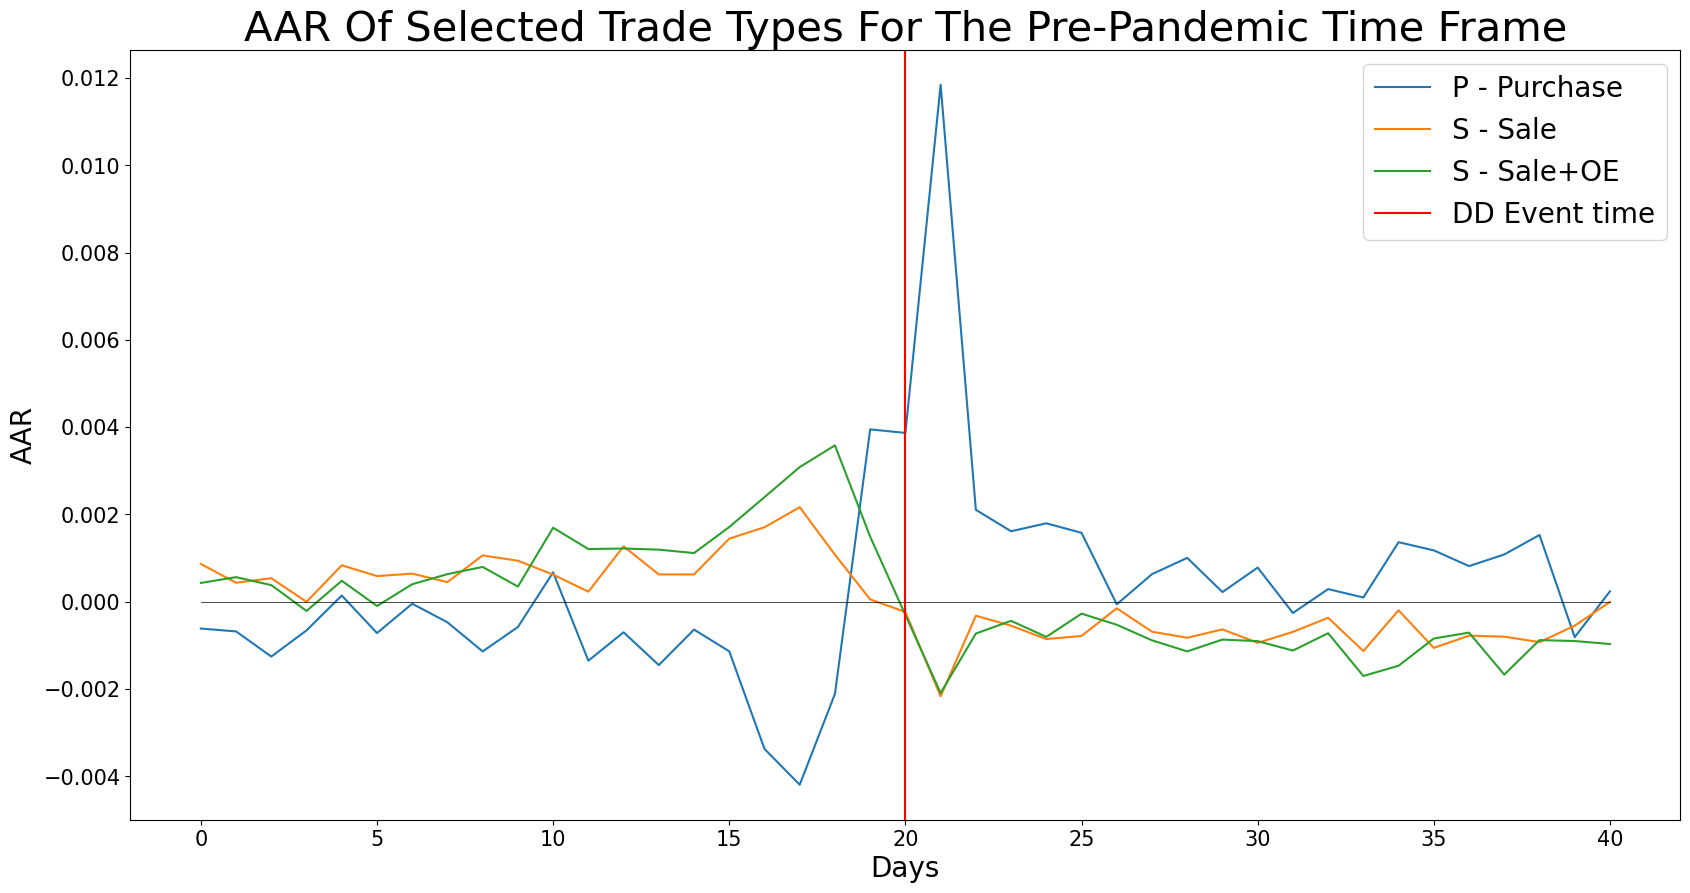

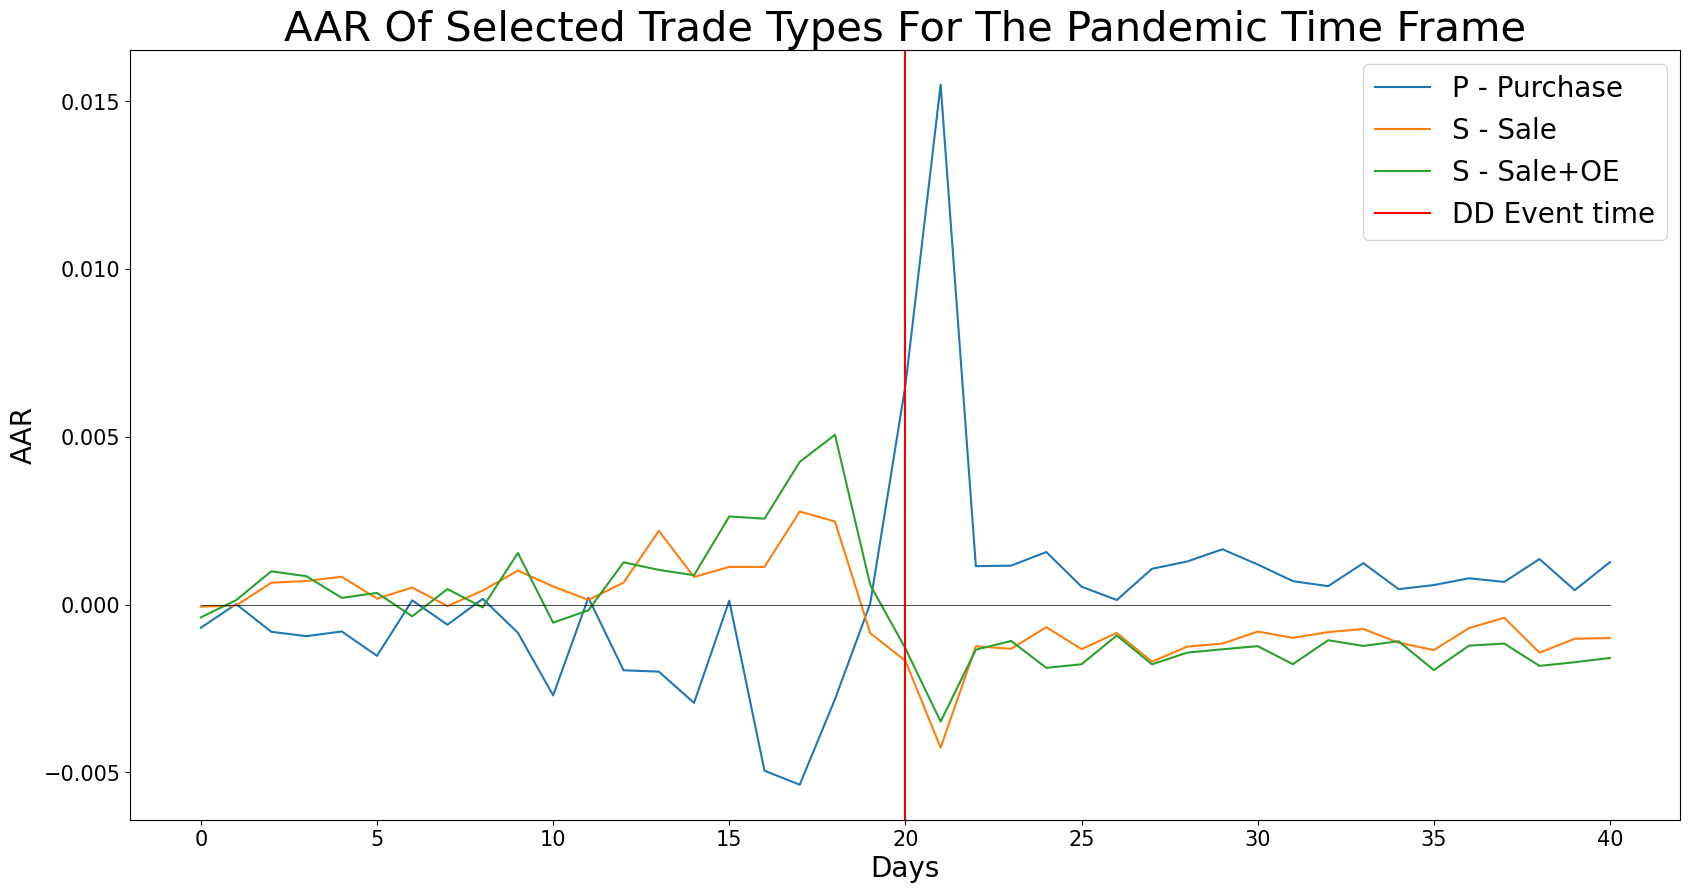

In [5]:
for investigation_period, (start, end) in investigation_periods.items():
    a = df_abnormal_returns.loc[:,:,types_of_interest,start:end].groupby(level=[2]).mean().transpose().plot(figsize=(fig_height, 10))
    plt.plot(np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
    a.set_title(f"AAR Of Selected Trade Types For The {investigation_period} Time Frame",fontsize=title_size)
    a.set_xlabel("Days", fontsize=label_size)
    a.set_ylabel("AAR", fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
    plt.legend(fontsize=label_size)
    plt.savefig(f"data/{NAME}/visualisations/AAR_selected_tradetypes_{investigation_period}.png", dpi=600, bbox_inches='tight')

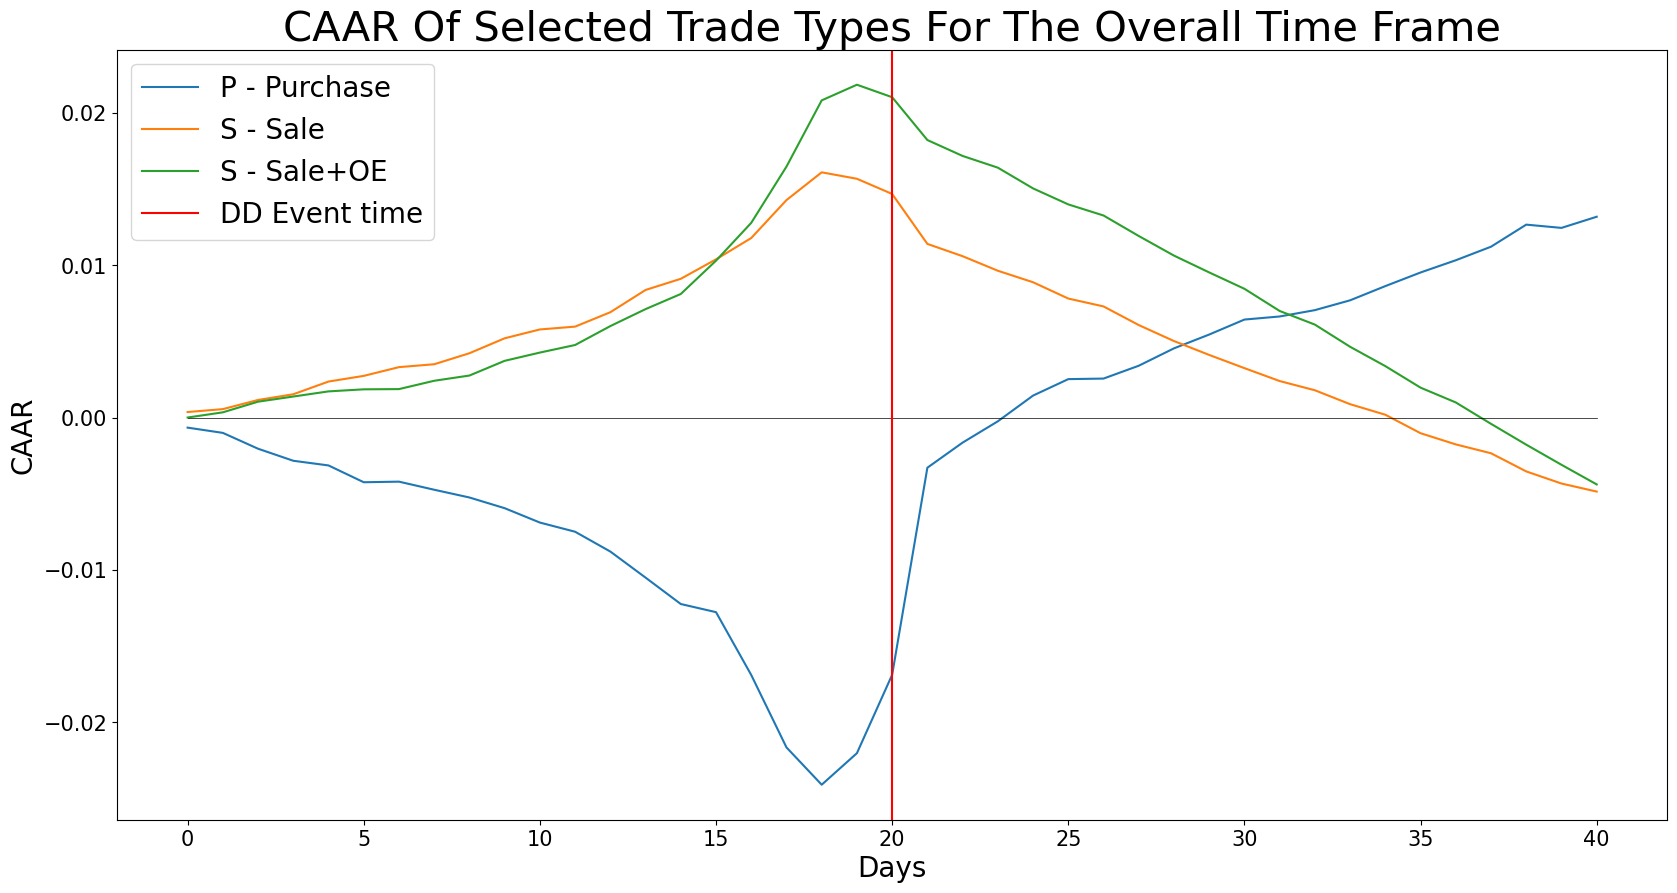

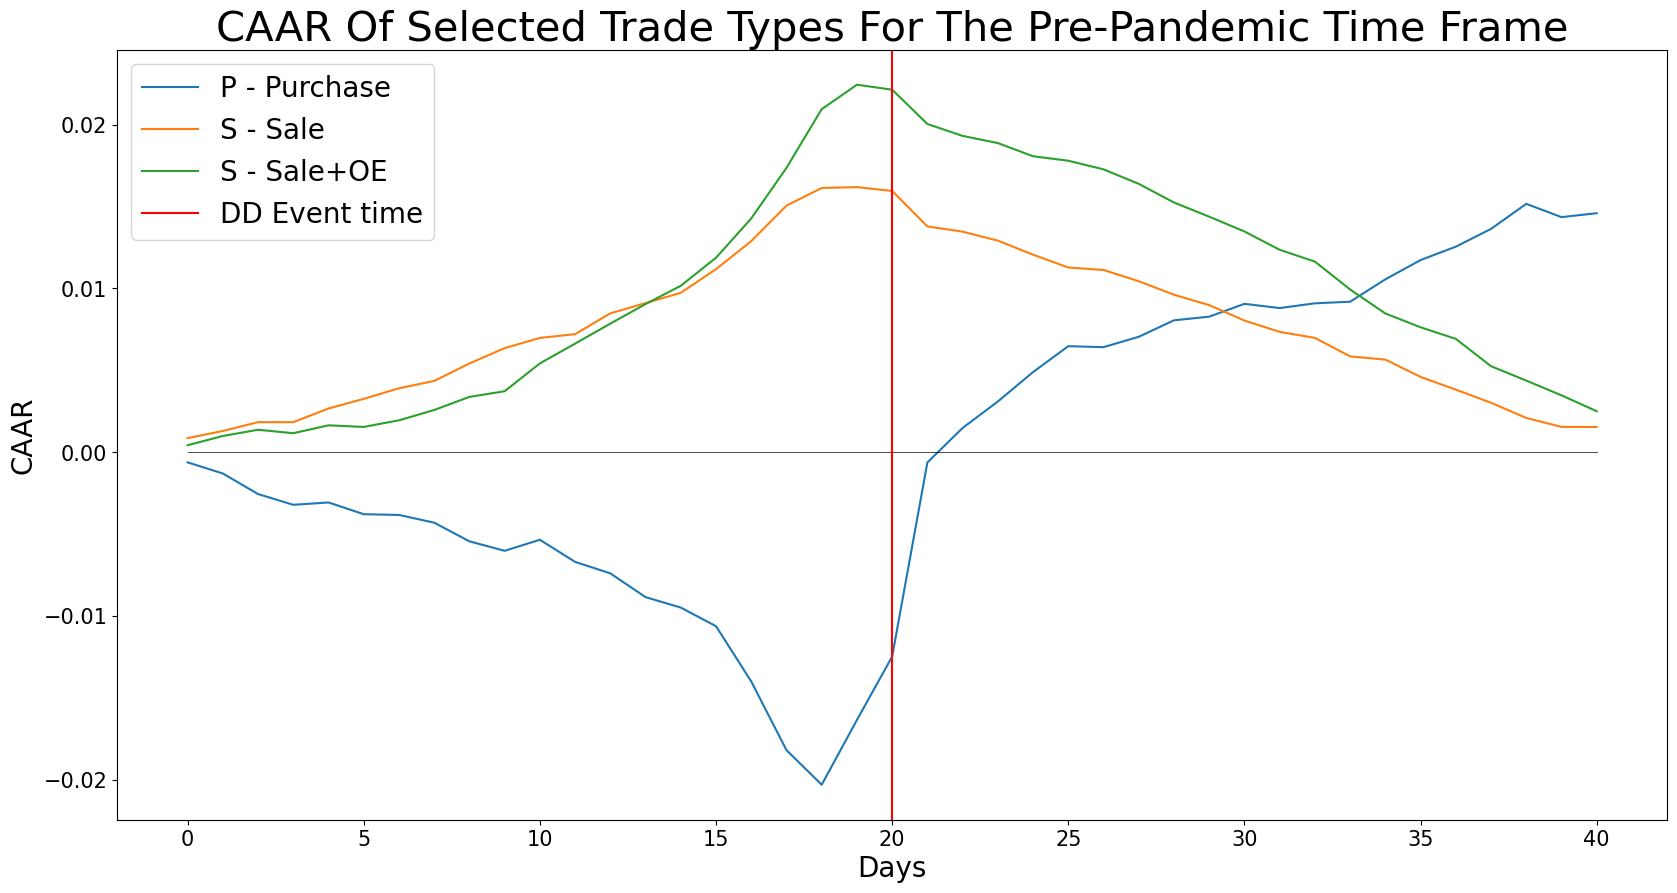

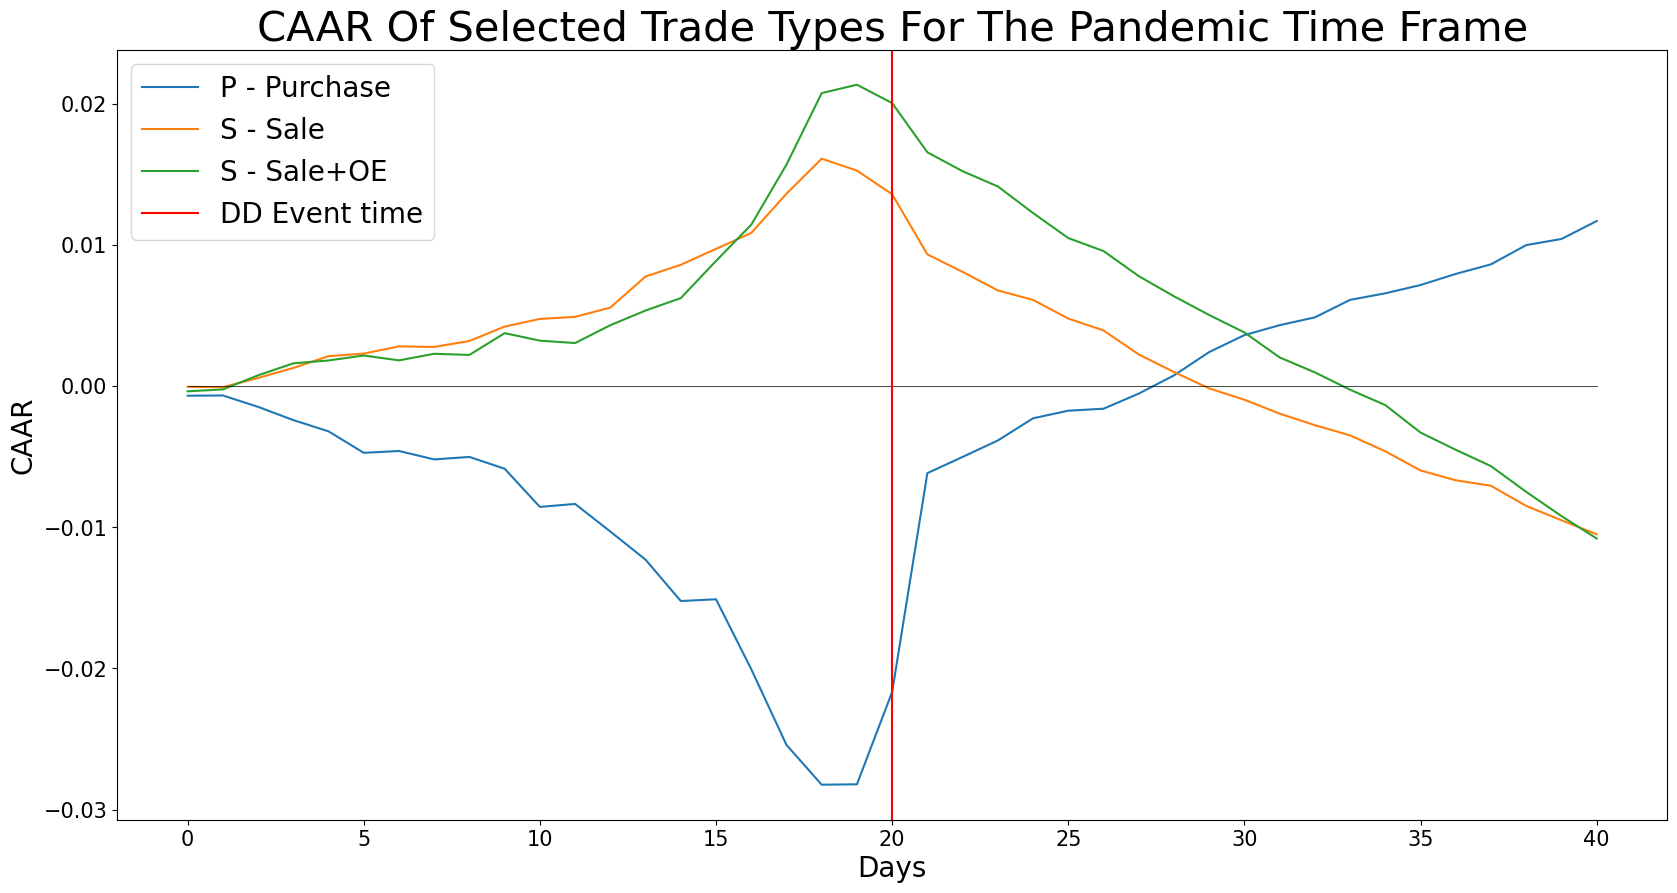

In [6]:
for investigation_period, (start, end) in investigation_periods.items():
    a = df_abnormal_returns.loc[:,:,types_of_interest,start:end].groupby(level=[2]).mean().transpose().cumsum().plot(figsize=(fig_height, 10))
    plt.plot(np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
    a.set_title(f"CAAR Of Selected Trade Types For The {investigation_period} Time Frame",fontsize=title_size)
    a.set_xlabel("Days", fontsize=label_size)
    a.set_ylabel("CAAR", fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
    plt.legend(fontsize=label_size)
    plt.savefig(f"data/{NAME}/visualisations/CAAR_selected_tradetypes_{investigation_period}.png", dpi=600, bbox_inches='tight')

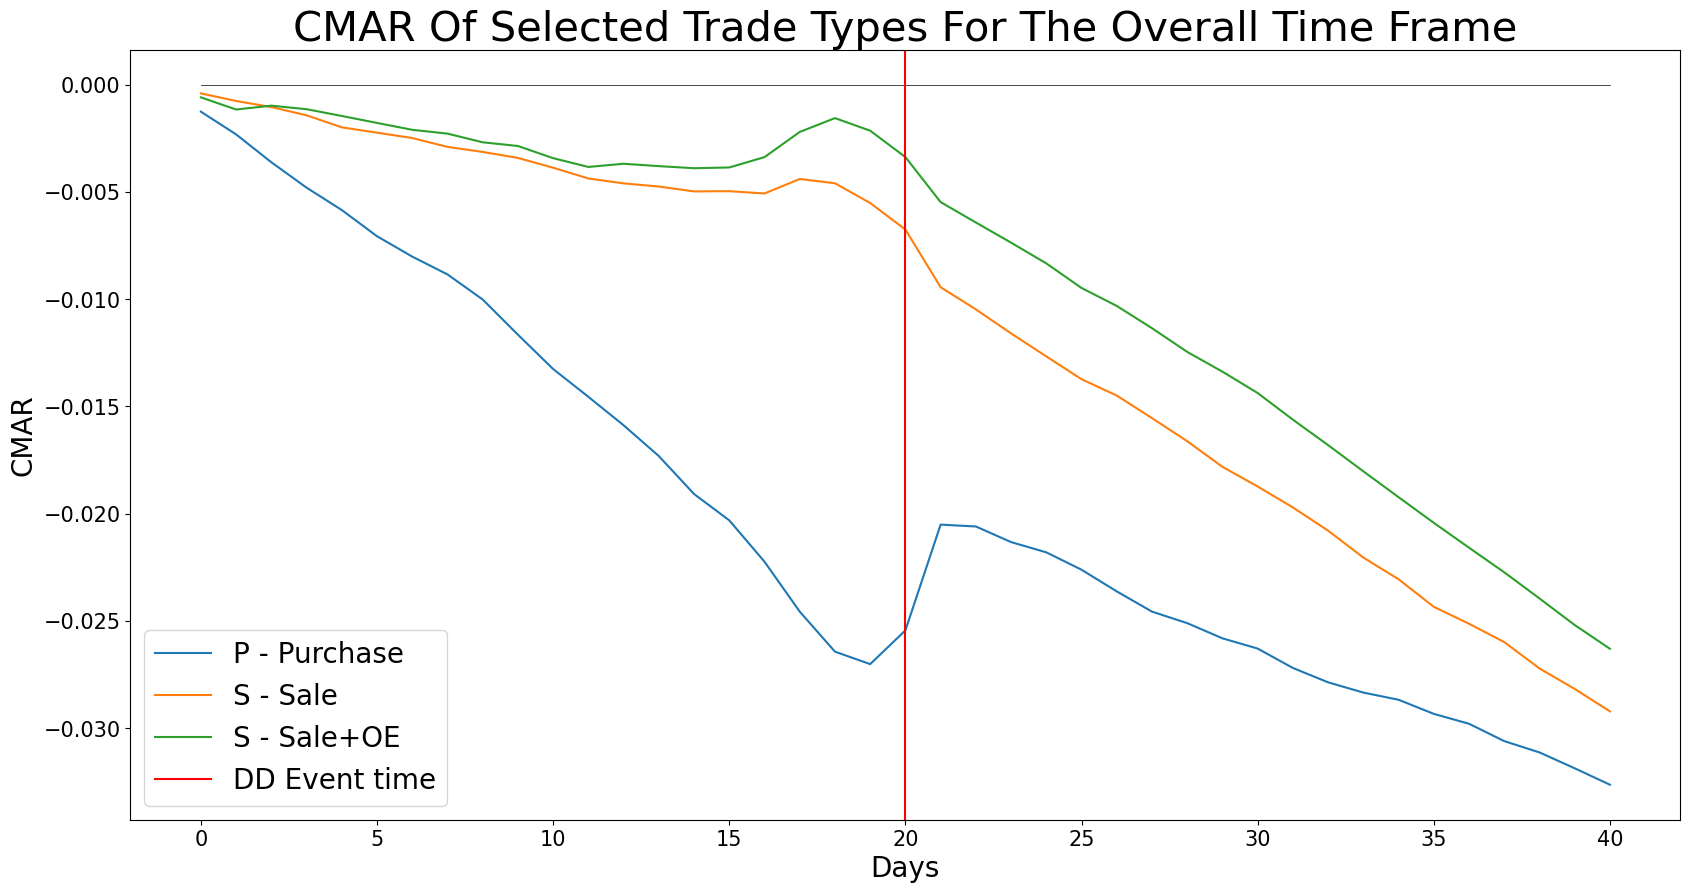

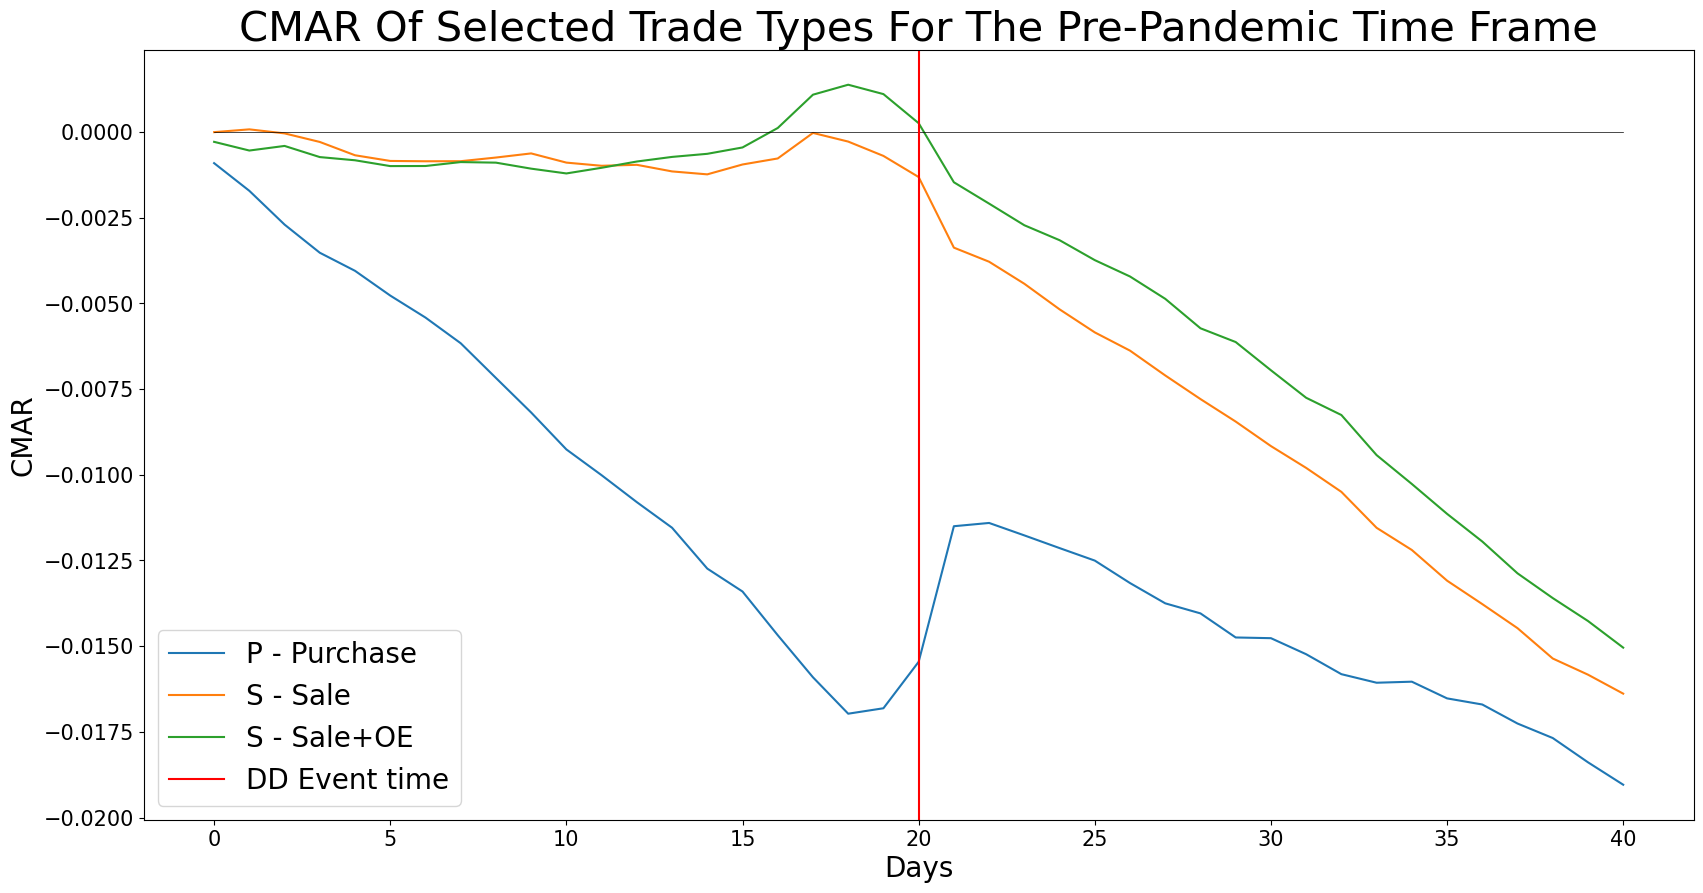

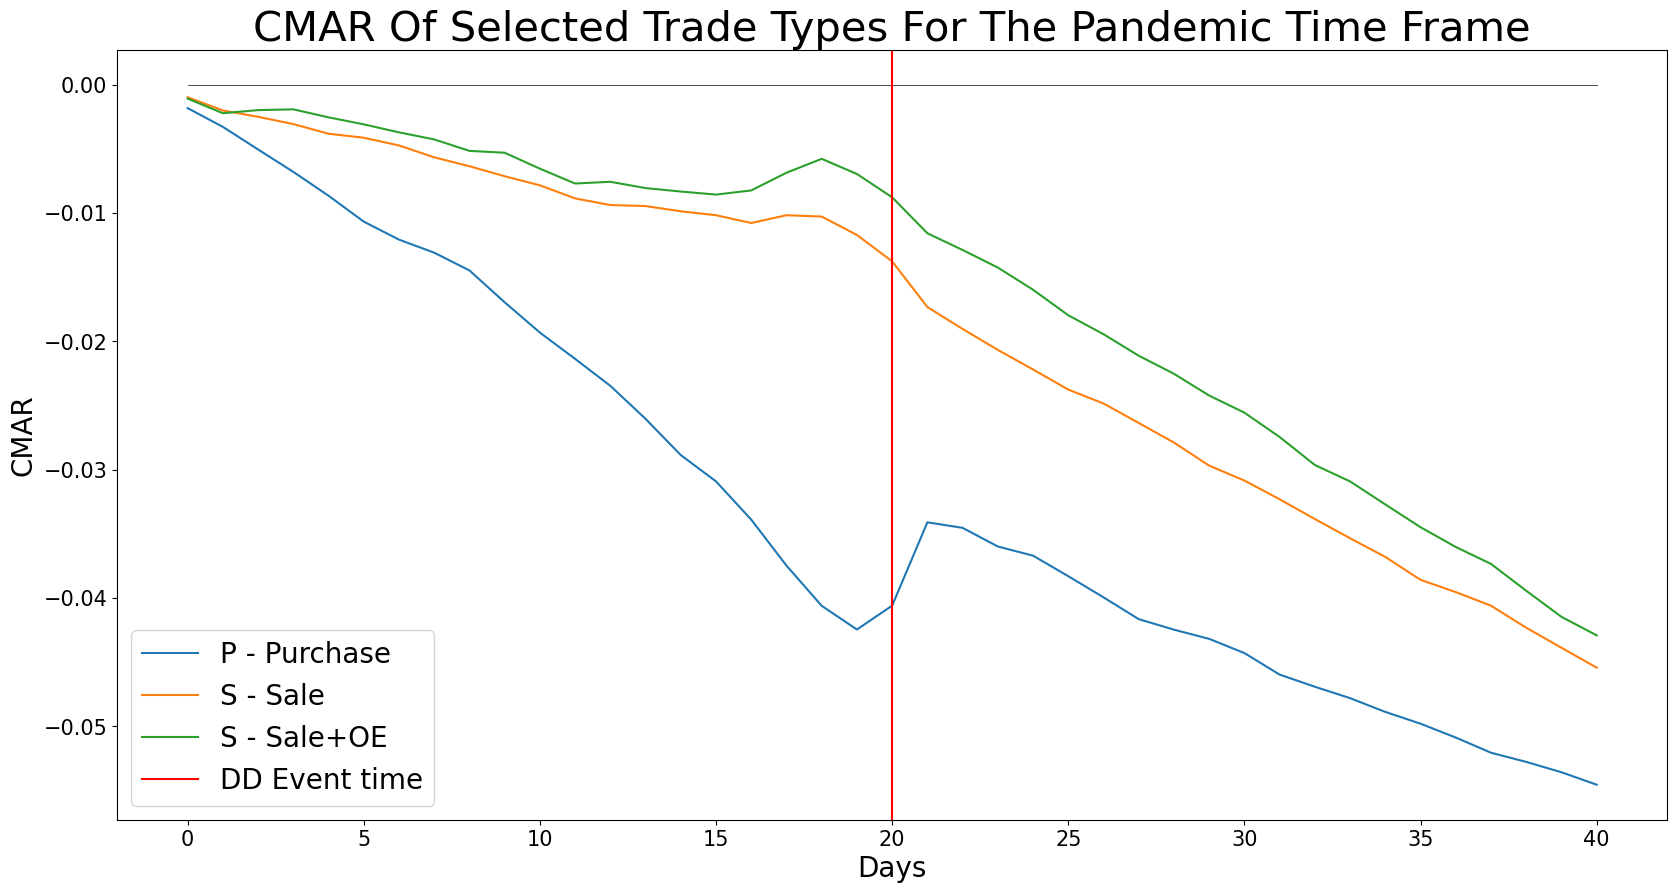

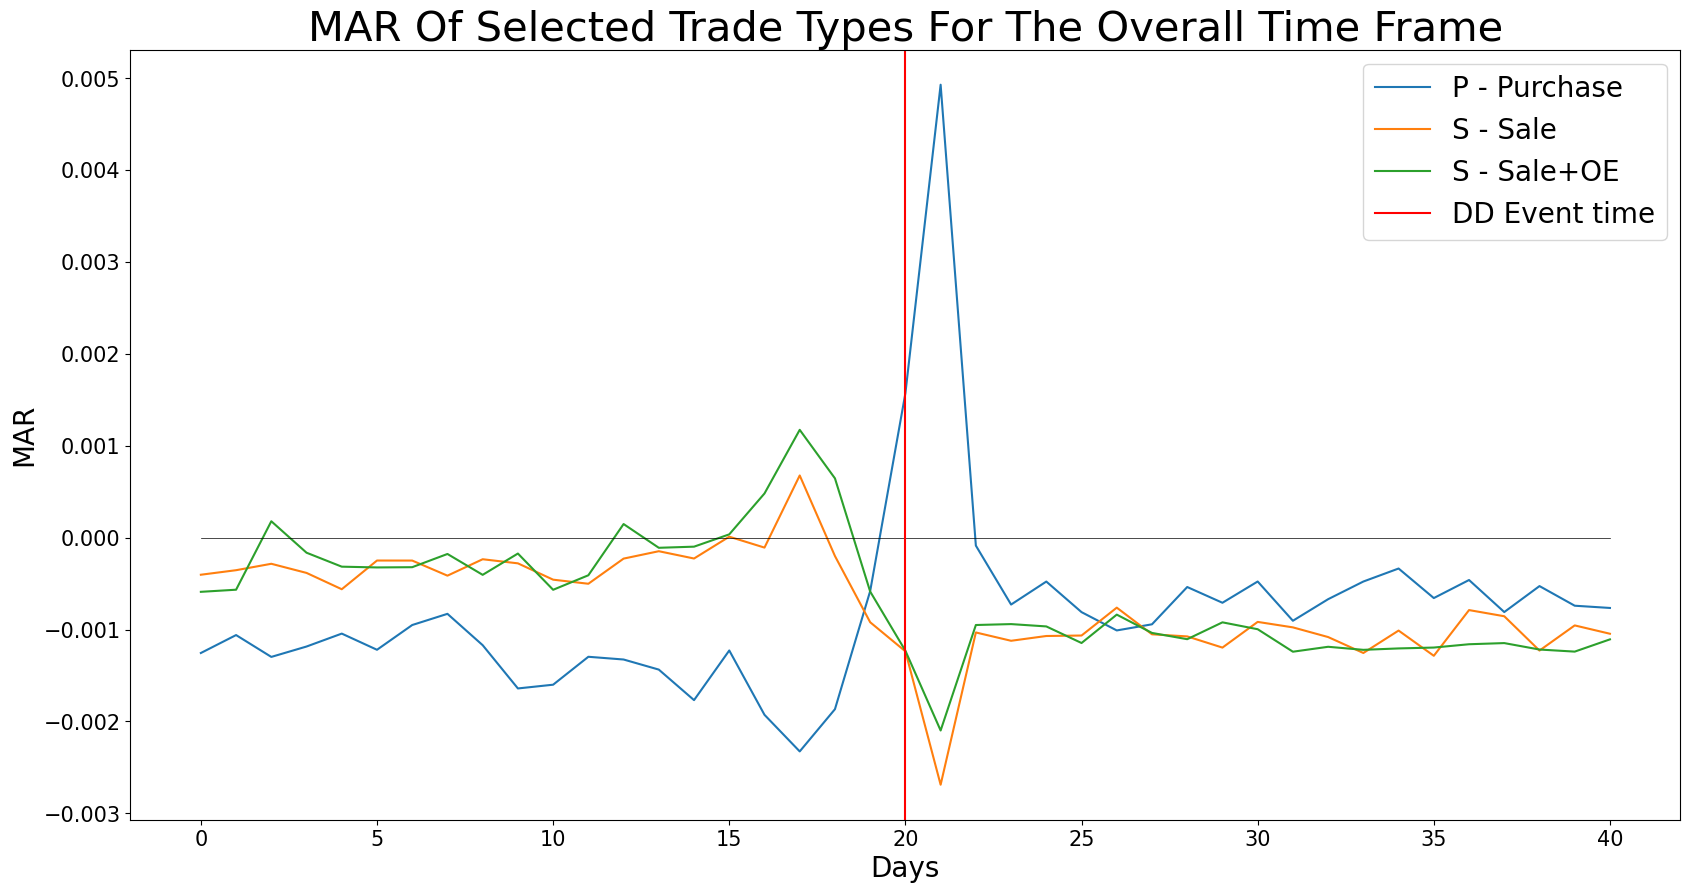

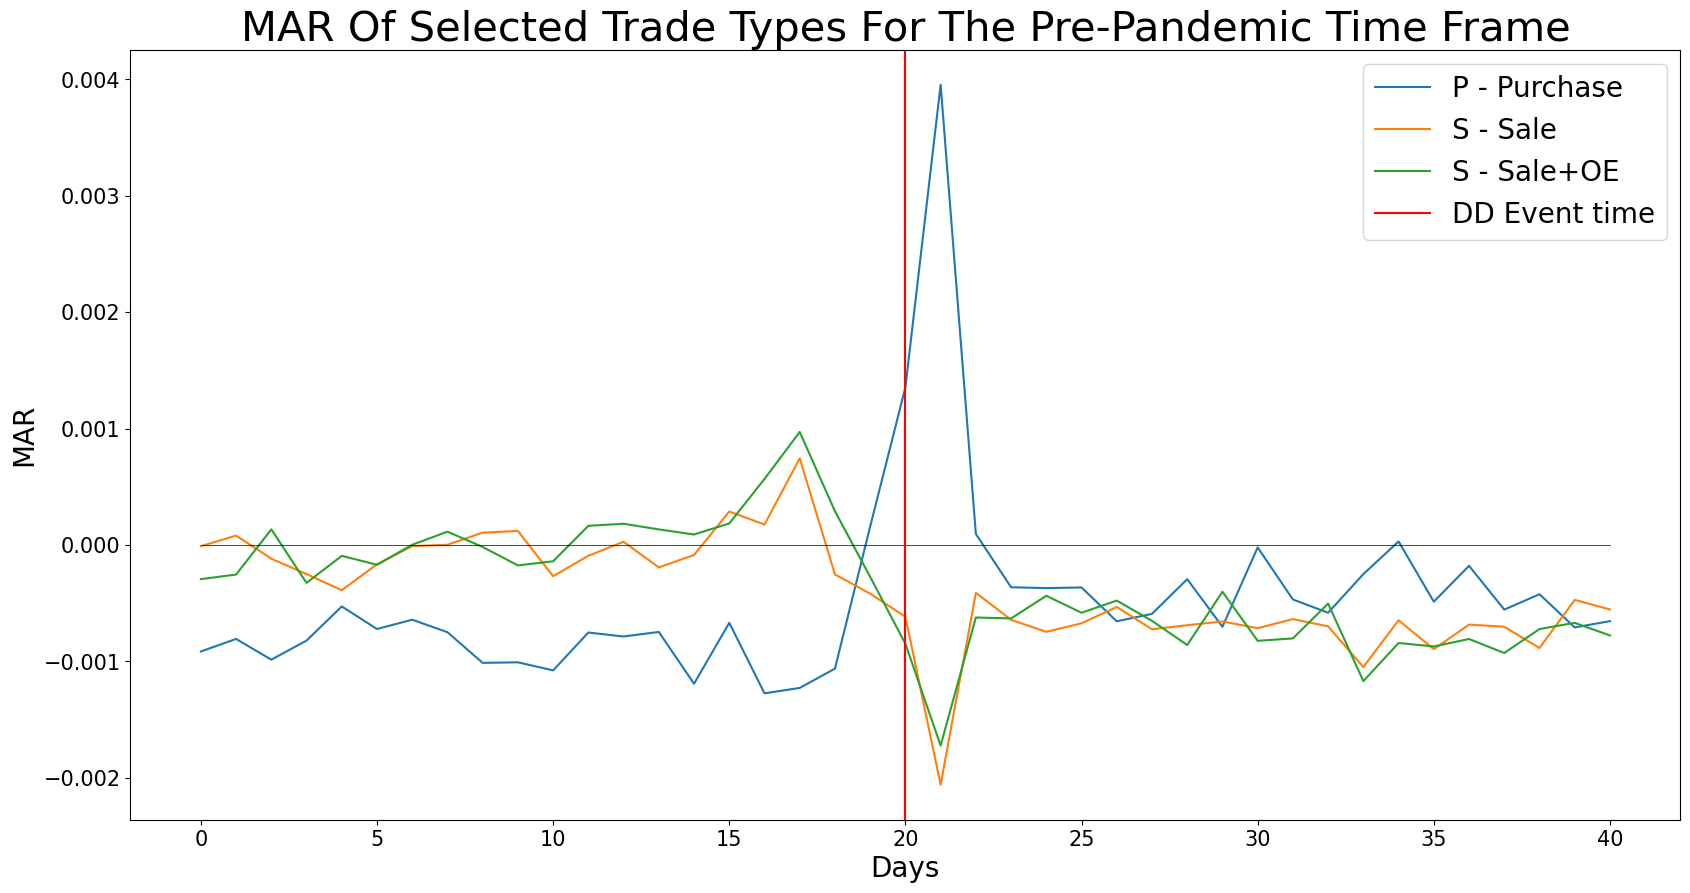

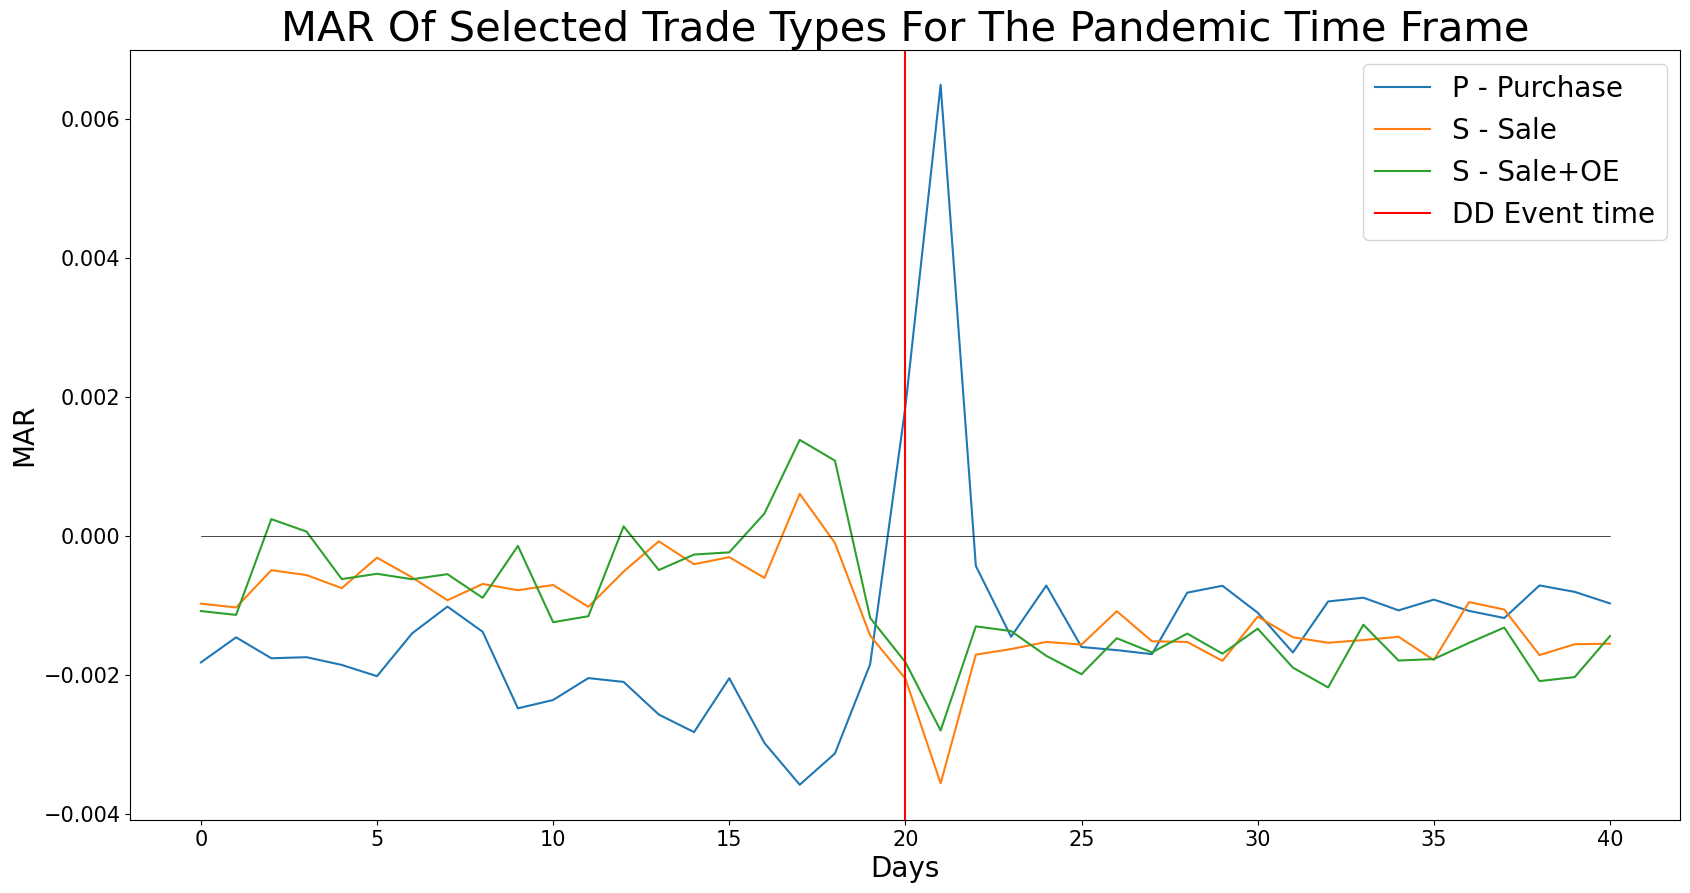

In [7]:
for investigation_period, (start, end) in investigation_periods.items():
    a = df_abnormal_returns.loc[:,:,types_of_interest,start:end].groupby(level=[2]).median().transpose().cumsum().plot(figsize=(fig_height, 10))
    plt.plot(np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
    a.set_title(f"CMAR Of Selected Trade Types For The {investigation_period} Time Frame",fontsize=title_size)
    a.set_xlabel("Days", fontsize=label_size)
    a.set_ylabel("CMAR", fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
    plt.legend(fontsize=label_size)
    plt.savefig(f"data/{NAME}/visualisations/CMAR_selected_tradetypes_{investigation_period}.png", dpi=600, bbox_inches='tight')

for investigation_period, (start, end) in investigation_periods.items():
    a = df_abnormal_returns.loc[:,:,types_of_interest,start:end].groupby(level=[2]).median().transpose().plot(figsize=(fig_height, 10))
    plt.plot(np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
    a.set_title(f"MAR Of Selected Trade Types For The {investigation_period} Time Frame",fontsize=title_size)
    a.set_xlabel("Days", fontsize=label_size)
    a.set_ylabel("MAR", fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
    plt.legend(fontsize=label_size)
    plt.savefig(f"data/{NAME}/visualisations/MAR_selected_tradetypes_{investigation_period}.png", dpi=600, bbox_inches='tight')

In [8]:
df_abnormal_returns

0         1         2   \
Company i  TradeType    event_timestamp                                 
AAL     15 A - Grant    2021-12-13      -0.057967  0.002927 -0.030288   
        16 A - Grant    2021-12-10      -0.015210 -0.057776  0.002976   
        17 A - Grant    2021-12-10      -0.015210 -0.057776  0.002976   
        18 F - Tax      2021-12-10      -0.015210 -0.057776  0.002976   
        19 A - Grant    2021-06-10      -0.035041  0.017527  0.048802   
...                                           ...       ...       ...   
ZYNE    21 P - Purchase 2018-08-07       0.018722  0.021104 -0.042874   
        22 P - Purchase 2018-05-31      -0.000572 -0.000392 -0.019119   
        23 P - Purchase 2018-05-02      -0.003070 -0.009494 -0.011637   
        24 P - Purchase 2018-03-23      -0.031393 -0.015181 -0.030031   
        25 P - Purchase 2018-01-03      -0.085740 -0.029176 -0.113322   

                                               3         4         5   \
Company i  TradeType    event_timestamp                                 
AAL     15 A - Grant    2021-12-13       0.005255 -0.027308 -0.008631   
        16 A - Grant    2021-12-10      -0.030130  0.005267 -0.027191   
        17 A - Grant    2021-12-10      -0.030130  0.005267 -0.027191   
        18 F - Tax      2021-12-10      -0.030130  0.005267 -0.027191   
        19 A - Grant    2021-06-10       0.040450  0.007403 -0.027812   
...                                           ...       ...       ...   
ZYNE    21 P - Purchase 2018-08-07       0.029754 -0.072087  0.047655   
        22 P - Purchase 2018-05-31       0.008808 -0.129481 -0.044530   
        23 P - Purchase 2018-05-02       0.002393  0.014414  0.060491   
        24 P - Purchase 2018-03-23      -0.021668  0.004479  0.034629   
        25 P - Purchase 2018-01-03       0.017313  0.008440 -0.043747   

                                               6         7         8   \
Company i  TradeType    event_timestamp                                 
AAL     15 A - Grant    2021-12-13       0.032061 -0.001986 -0.004101   
        16 A - Grant    2021-12-10      -0.008522  0.031943 -0.002001   
        17 A - Grant    2021-12-10      -0.008522  0.031943 -0.002001   
        18 F - Tax      2021-12-10      -0.008522  0.031943 -0.002001   
        19 A - Grant    2021-06-10      -0.022252 -0.003135  0.013106   
...                                           ...       ...       ...   
ZYNE    21 P - Purchase 2018-08-07       0.007432  0.028267 -0.238789   
        22 P - Purchase 2018-05-31       0.006852  0.056728  0.023828   
        23 P - Purchase 2018-05-02       0.017077  0.033012 -0.019536   
        24 P - Purchase 2018-03-23      -0.055589 -0.051696 -0.013868   
        25 P - Purchase 2018-01-03      -0.022290  0.047257 -0.027763   

                                               9   ...        31        32  \
Company i  TradeType    event_timestamp            ...                       
AAL     15 A - Grant    2021-12-13      -0.064043  ... -0.024457  0.003754   
        16 A - Grant    2021-12-10      -0.003986  ...  0.027196 -0.024416   
        17 A - Grant    2021-12-10      -0.003986  ...  0.027196 -0.024416   
        18 F - Tax      2021-12-10      -0.003986  ...  0.027196 -0.024416   
        19 A - Grant    2021-06-10       0.006906  ... -0.008416 -0.041995   
...                                           ...  ...       ...       ...   
ZYNE    21 P - Purchase 2018-08-07       0.008946  ... -0.010091  0.009126   
        22 P - Purchase 2018-05-31       0.011434  ... -0.013942 -0.006108   
        23 P - Purchase 2018-05-02       0.014713  ...  0.046883  0.052797   
        24 P - Purchase 2018-03-23      -0.015829  ...  0.011735  0.058119   
        25 P - Purchase 2018-01-03       0.003056  ...  0.000048  0.008298   

                                               33        34        35  \
Company i  TradeType    event_timestamp                                 
AAL     15 A - Grant    2021-12-13  

I think OE and OptEx means option exercise. "to exercise" means to put into effect the right to buy or sell the underlying security that is specified in the options contract." Can we be sure that the action does not shift the market, and the swing in return is really due to new information? Are these trades public, so maybe they are used as a signal for traders?

### Boxplot of the sum over all companies's AR

![alt text](assets/images/time_agg.png)

In our case it is not company i, but filing i

Types of trade to pick from:

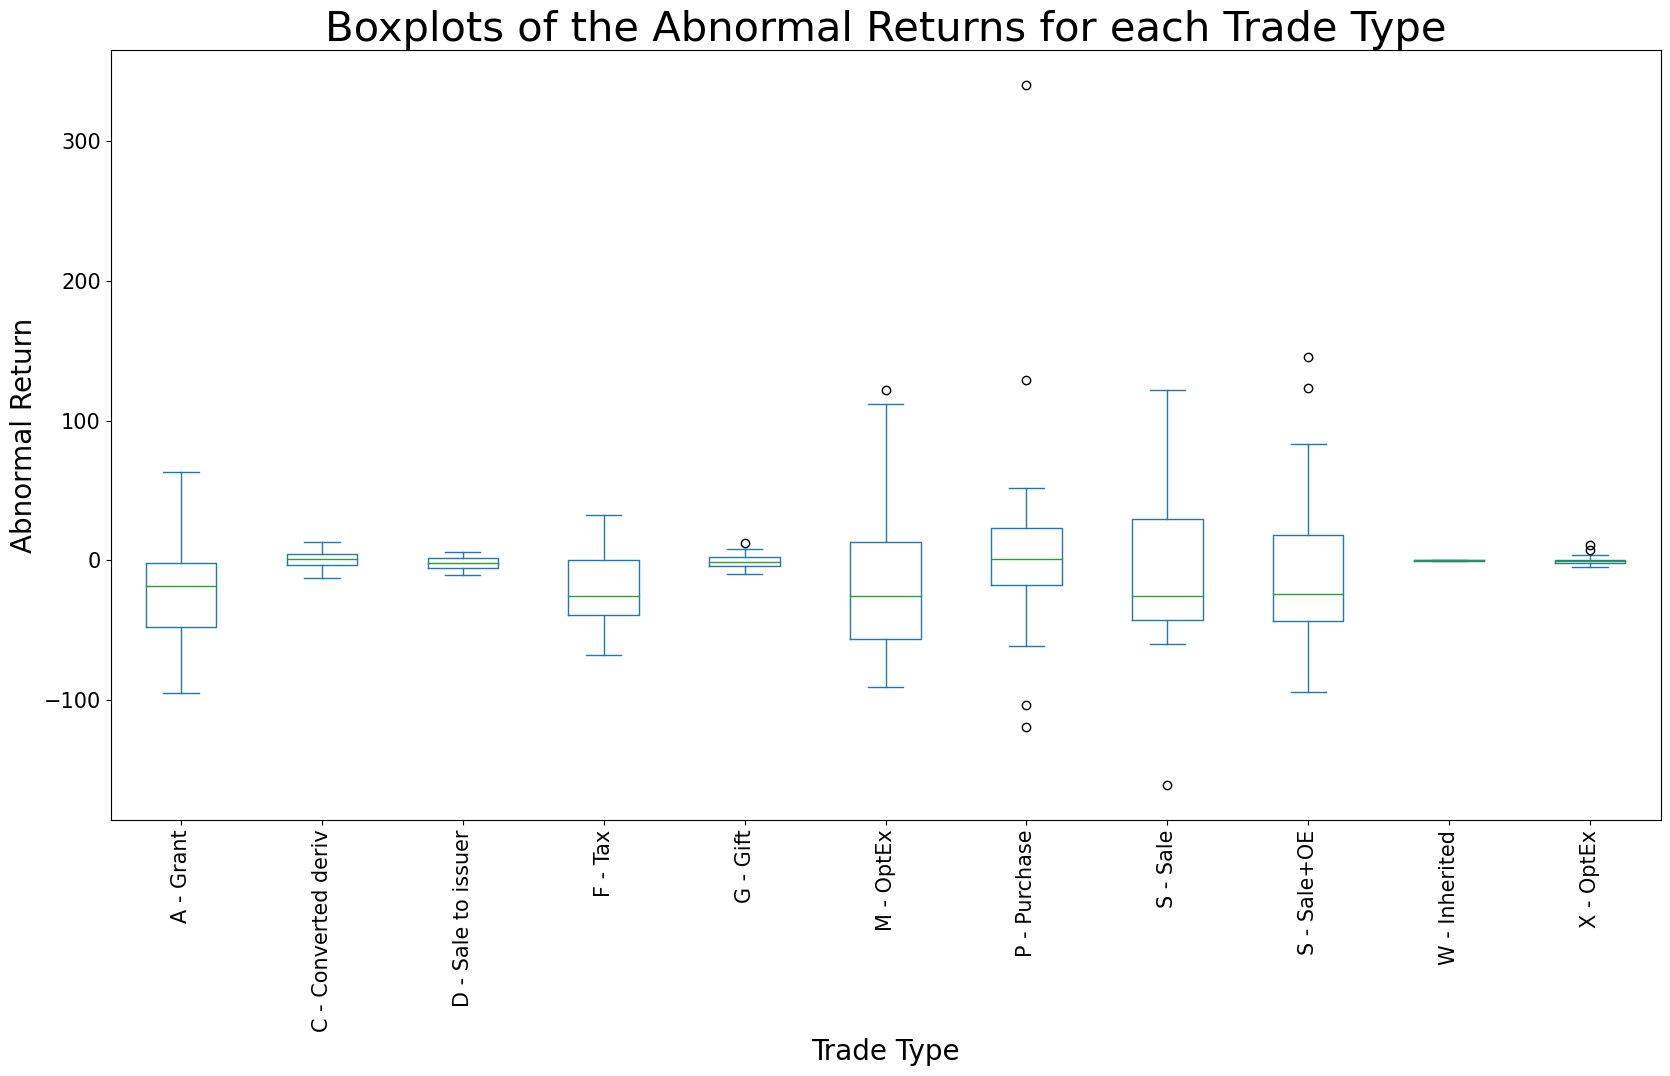

In [9]:
ax = df_abnormal_returns.groupby(level=[2]).sum().transpose().plot.box(rot=90, figsize=(fig_height, 10))
ax.set_title("Boxplots of the Abnormal Returns for each Trade Type",fontsize=title_size)
ax.set_xlabel("Trade Type", fontsize=label_size)
ax.set_ylabel("Abnormal Return", fontsize=label_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.savefig(f"data/{NAME}/visualisations/AR_all_tradetypes_boxplot.png", dpi=600, bbox_inches='tight')

In [10]:
types = list(set([x[2] for x in df_abnormal_returns.index]))
types

['P - Purchase',
 'S - Sale',
 'F - Tax',
 'D - Sale to issuer',
 'M - OptEx',
 'X - OptEx',
 'S - Sale+OE',
 'A - Grant',
 'G - Gift',
 'C - Converted deriv',
 'W - Inherited']

Specify the type of the trades to investigate

In [11]:
type_ = "P - Purchase" # "S - Sale"
df_abnormal_returns_type = df_abnormal_returns.loc[:,:,type_]

The index describes the company and the index of the filing in the compnay, the columns represent the days in the event window

In [12]:
df_abnormal_returns_type

0         1         2         3         4   \
Company i  event_timestamp                                                     
AAL     59 2020-03-03      -0.010010  0.014602  0.018292 -0.037311  0.014914   
        60 2020-03-03      -0.010010  0.014602  0.018292 -0.037311  0.014914   
        61 2020-02-25      -0.023042  0.009097 -0.002792  0.031973 -0.004239   
        75 2019-10-28      -0.009376  0.010573 -0.030671 -0.017038  0.005934   
        77 2019-08-30       0.006075  0.016889 -0.019784  0.005841 -0.012870   
...                              ...       ...       ...       ...       ...   
ZYNE    21 2018-08-07       0.018722  0.021104 -0.042874  0.029754 -0.072087   
        22 2018-05-31      -0.000572 -0.000392 -0.019119  0.008808 -0.129481   
        23 2018-05-02      -0.003070 -0.009494 -0.011637  0.002393  0.014414   
        24 2018-03-23      -0.031393 -0.015181 -0.030031 -0.021668  0.004479   
        25 2018-01-03      -0.085740 -0.029176 -0.113322  0.017313  0.008440   

                                  5         6         7         8         9   \
Company i  event_timestamp                                                     
AAL     59 2020-03-03      -0.003687  0.037134  0.007239 -0.007313 -0.030570   
        60 2020-03-03      -0.003687  0.037134  0.007239 -0.007313 -0.030570   
        61 2020-02-25      -0.007821  0.018492  0.018459 -0.036591  0.012963   
        75 2019-10-28       0.006371  0.040641  0.019215 -0.001585 -0.009145   
        77 2019-08-30       0.004150 -0.022081 -0.029290 -0.009721 -0.023736   
...                              ...       ...       ...       ...       ...   
ZYNE    21 2018-08-07       0.047655  0.007432  0.028267 -0.238789  0.008946   
        22 2018-05-31      -0.044530  0.006852  0.056728  0.023828  0.011434   
        23 2018-05-02       0.060491  0.017077  0.033012 -0.019536  0.014713   
        24 2018-03-23       0.034629 -0.055589 -0.051696 -0.013868 -0.015829   
        25 2018-01-03      -0.043747 -0.022290  0.047257 -0.027763  0.003056   

                            ...        31        32        33        34  \
Company i  event_timestamp  ...                                           
AAL     59 2020-03-03       ... -0.163283 -0.156244  0.080822 -0.005024   
        60 2020-03-03       ... -0.163283 -0.156244  0.080822 -0.005024   
        61 2020-02-25       ...  0.034121 -0.019232 -0.084931  0.313092   
        75 2019-10-28       ... -0.036405 -0.026442  0.006094 -0.004475   
        77 2019-08-30       ...  0.027497  0.001505 -0.009941  0.001098   
...                         ...       ...       ...       ...       ...   
ZYNE    21 2018-08-07       ... -0.010091  0.009126 -0.006430  0.020222   
        22 2018-05-31       ... -0.013942 -0.006108 -0.026237  0.089463   
        23 2018-05-02       ...  0.046883  0.052797 -0.032499  0.039374   
        24 2018-03-23       ...  0.011735  0.058119  0.014532  0.030655   
        25 2018-01-03       ...  0.000048  0.008298 -0.030083  0.028617   

                                  35        36        37        38        39  \
Company i  event_timestamp                                                     
AAL     59 2020-03-03       0.211710  0.116594 -0.082424 -0.031342 -0.191482   
        60 2020-03-03       0.211710  0.116594 -0.082424 -0.031342 -0.191482   
        61 2020-02-25      -0.120007 -0.174589 -0.151899  0.071579 -0.006438   
        75 2019-10-28      -0.008409  0.022899 -0.027790 -0.005418  0.026726   
        77 2019-08-30      -0.015156  0.002783  0.003953  0.000137  0.009878   
...                              ...       ...       ...       ...       ...   
ZYNE    21 2018-08-07       0.051008  0.168674  0.007592 -0.000995  0.014532   
        22 2018-05-31       0.051694 -0.062224 -0.075411  0.040058 -0.092464   
        23 2018-05-02       0.004273 -0.031825  0.006298  0.016867 -0.012485   
        24 2018-03-23      -0.022042  0.012075 -0.036748  0.041524  0.034871   
        25 2018-

In [13]:
df_abnormal_returns.loc[:,:, types_of_interest].groupby(level=[2]).count()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
TradeType,,,,,,,,,,,,,,,,,,,,,
P - Purchase,25030,25030,25030,25030,25030,25030,25030,25030,25030,25029,...,25028,25028,25028,25028,25028,25028,25028,25028,25028,25028
S - Sale,49043,49043,49043,49043,49043,49043,49043,49043,49043,49043,...,49043,49043,49043,49043,49043,49043,49043,49043,49043,49043
S - Sale+OE,33485,33485,33485,33485,33485,33485,33485,33485,33485,33485,...,33485,33485,33485,33485,33485,33485,33485,33485,33485,33485


In [14]:
CAR = df_abnormal_returns.cumsum(axis =1).loc[:,:, types_of_interest]

In [15]:
# aggregate on time axis
CAAR = CAR.groupby(level=[2]).mean().transpose()
print(CAAR.describe().to_latex())

\begin{tabular}{lrrr}
\toprule
TradeType &  P - Purchase &   S - Sale &  S - Sale+OE \\
\midrule
count &     41.000000 &  41.000000 &    41.000000 \\
mean  &     -0.001738 &   0.005024 &     0.007322 \\
std   &      0.009881 &   0.005452 &     0.007081 \\
min   &     -0.024057 &  -0.004848 &    -0.004376 \\
25\%   &     -0.006845 &   0.001167 &     0.001865 \\
50\%   &     -0.001556 &   0.004235 &     0.006018 \\
75\%   &      0.006522 &   0.008895 &     0.012796 \\
max   &      0.013273 &   0.016112 &     0.021864 \\
\bottomrule
\end{tabular}



C:\Users\waxfa\AppData\Local\Temp\ipykernel_30448\2729430084.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(CAAR.describe().to_latex())


In [16]:
CAR

0         1         2   \
Company i  TradeType    event_timestamp                                 
AAL     59 P - Purchase 2020-03-03      -0.010010  0.004593  0.022884   
        60 P - Purchase 2020-03-03      -0.010010  0.004593  0.022884   
        61 P - Purchase 2020-02-25      -0.023042 -0.013945 -0.016737   
        75 P - Purchase 2019-10-28      -0.009376  0.001197 -0.029474   
        77 P - Purchase 2019-08-30       0.006075  0.022964  0.003180   
...                                           ...       ...       ...   
ZYNE    21 P - Purchase 2018-08-07       0.018722  0.039826 -0.003048   
        22 P - Purchase 2018-05-31      -0.000572 -0.000964 -0.020084   
        23 P - Purchase 2018-05-02      -0.003070 -0.012564 -0.024201   
        24 P - Purchase 2018-03-23      -0.031393 -0.046574 -0.076605   
        25 P - Purchase 2018-01-03      -0.085740 -0.114917 -0.228239   

                                               3         4         5   \
Company i  TradeType    event_timestamp                                 
AAL     59 P - Purchase 2020-03-03      -0.014427  0.000487 -0.003200   
        60 P - Purchase 2020-03-03      -0.014427  0.000487 -0.003200   
        61 P - Purchase 2020-02-25       0.015236  0.010996  0.003175   
        75 P - Purchase 2019-10-28      -0.046513 -0.040579 -0.034207   
        77 P - Purchase 2019-08-30       0.009020 -0.003850  0.000300   
...                                           ...       ...       ...   
ZYNE    21 P - Purchase 2018-08-07       0.026706 -0.045381  0.002274   
        22 P - Purchase 2018-05-31      -0.011276 -0.140758 -0.185288   
        23 P - Purchase 2018-05-02      -0.021808 -0.007394  0.053097   
        24 P - Purchase 2018-03-23      -0.098273 -0.093794 -0.059165   
        25 P - Purchase 2018-01-03      -0.210926 -0.202486 -0.246233   

                                               6         7         8   \
Company i  TradeType    event_timestamp                                 
AAL     59 P - Purchase 2020-03-03       0.033934  0.041174  0.033861   
        60 P - Purchase 2020-03-03       0.033934  0.041174  0.033861   
        61 P - Purchase 2020-02-25       0.021667  0.040126  0.003535   
        75 P - Purchase 2019-10-28       0.006434  0.025649  0.024064   
        77 P - Purchase 2019-08-30      -0.021780 -0.051070 -0.060791   
...                                           ...       ...       ...   
ZYNE    21 P - Purchase 2018-08-07       0.009706  0.037973 -0.200816   
        22 P - Purchase 2018-05-31      -0.178436 -0.121708 -0.097880   
        23 P - Purchase 2018-05-02       0.070174  0.103187  0.083651   
        24 P - Purchase 2018-03-23      -0.114753 -0.166449 -0.180318   
        25 P - Purchase 2018-01-03      -0.268523 -0.221265 -0.249029   

                                               9   ...        31        32  \
Company i  TradeType    event_timestamp            ...                       
AAL     59 P - Purchase 2020-03-03       0.003291  ... -0.201691 -0.357935   
        60 P - Purchase 2020-03-03       0.003291  ... -0.201691 -0.357935   
        61 P - Purchase 2020-02-25       0.016498  ... -0.183543 -0.202775   
        75 P - Purchase 2019-10-28       0.014919  ...  0.073283  0.046841   
        77 P - Purchase 2019-08-30      -0.084527  ...  0.002382  0.003887   
...                                           ...  ...       ...       ...   
ZYNE    21 P - Purchase 2018-08-07      -0.191870  ... -0.390692 -0.381566   
        22 P - Purchase 2018-05-31      -0.086445  ...  0.099252  0.093144   
        23 P - Purchase 2018-05-02       0.098364  ...  0.083246  0.136043   
        24 P - Purchase 2018-03-23      -0.196146  ... -0.135389 -0.077270   
        25 P - Purchase 2018-01-03      -0.245973  ... -0.278463 -0.270165   

                                               33        34        35  \
Company i  TradeType    event_timestamp                                 
AAL     59 P - Purchase 2020-03-03  

In [17]:
# aggregate on filings axis
results = []
index_stats = []
for type_ in types_of_interest:
    for ip in investigation_periods:
        for cp in CAR_periods:
            l, r = investigation_periods[ip]
            l_CAR, r_CAR = CAR_periods[cp]
            res = CAR.loc[:,:,type_,l:r].iloc[:,l_CAR:(r_CAR+1)].mean(axis=1).groupby(level=[2]).describe().transpose()
            res = res.round(4)
            res.loc["count"] = res.loc["count"].astype(int).astype(str)
            results.append(res.transpose())
            index_stats.append((type_, ip, cp))

In [18]:
stats_df = pd.concat(results)
stats_df.index = pd.MultiIndex.from_tuples(index_stats, names=["Trade Type", "Investigation Period", "CAR period"])
print(stats_df.to_latex())

\begin{tabular}{lllllllllll}
\toprule
            &          &        &  count &    mean &     std &     min &     25\% &     50\% &     75\% &     max \\
Trade Type & Investigation Period & CAR period &        &         &         &         &         &         &         &         \\
\midrule
P - Purchase & Overall & [-20, 20] &  25030 & -0.0017 &  0.1996 & -2.3084 & -0.0849 & -0.0092 &  0.0699 &  6.8303 \\
            &          & [-20, -1] &  25030 & -0.0088 &  0.1256 & -2.0062 & -0.0567 & -0.0104 &  0.0347 &  4.2081 \\
            &          & [0, 20] &  25028 &   0.005 &  0.2883 & -3.0222 & -0.1129 &  -0.007 &  0.1059 &  9.3276 \\
            &          & [0, 5] &  25028 & -0.0029 &  0.2645 &  -2.095 & -0.1053 &   -0.01 &  0.0871 &  9.2574 \\
            &          & [0, 1] &  25028 &   -0.01 &  0.2562 & -1.9094 &  -0.107 & -0.0135 &  0.0761 &  9.1677 \\
            & Pre-Pandemic & [-20, 20] &  13039 &  0.0003 &  0.1848 & -1.3515 & -0.0725 & -0.0087 &  0.0588 &  2.7998 \\
         

C:\Users\waxfa\AppData\Local\Temp\ipykernel_30448\2457059172.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_df.to_latex())


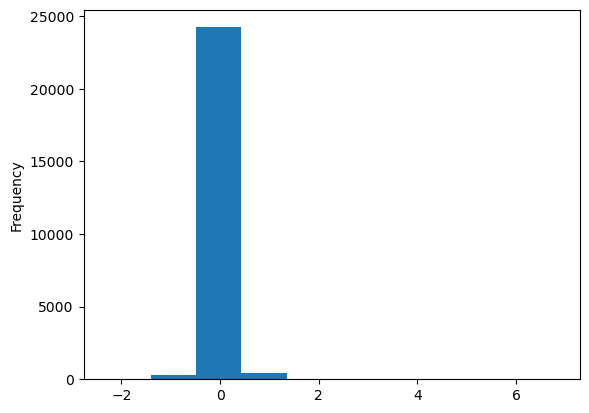

In [19]:
type_ = "P - Purchase"
l,r = investigation_periods["Overall"]
l_CAR, r_CAR = CAR_periods["[-20, 20]"]
CAR.loc[:,:,type_,l:r].iloc[:,l_CAR:(r_CAR+1)].mean(axis=1).plot(kind="hist")
plt.show()

In [20]:
stats_df

count    mean     std     min  \
Trade Type   Investigation Period CAR period                                  
P - Purchase Overall              [-20, 20]   25030 -0.0017  0.1996 -2.3084   
                                  [-20, -1]   25030 -0.0088  0.1256 -2.0062   
                                  [0, 20]     25028   0.005  0.2883 -3.0222   
                                  [0, 5]      25028 -0.0029  0.2645  -2.095   
                                  [0, 1]      25028   -0.01  0.2562 -1.9094   
             Pre-Pandemic         [-20, 20]   13039  0.0003  0.1848 -1.3515   
                                  [-20, -1]   13039 -0.0075  0.1177 -1.2135   
                                  [0, 20]     13037  0.0078  0.2661 -1.6319   
                                  [0, 5]      13037  0.0006  0.2411 -1.5675   
                                  [0, 1]      13037 -0.0064  0.2355 -1.6217   
             Pandemic             [-20, 20]   11991  -0.004  0.2145 -2.3084   
                                  [-20, -1]   11991 -0.0103  0.1336 -2.0062   
                                  [0, 20]     11991   0.002  0.3107 -3.0222   
                                  [0, 5]      11991 -0.0068  0.2878  -2.095   
                                  [0, 1]      11991 -0.0139  0.2768 -1.9094   
S - Sale     Overall              [-20, 20]   49043   0.005  0.1592  -2.308   
                                  [-20, -1]   49043  0.0065   0.103 -1.4885   
                                  [0, 20]     49043  0.0036  0.2273 -3.0886   
                                  [0, 5]      49043  0.0105  0.2047  -2.511   
                                  [0, 1]      49043  0.0131  0.1996 -2.3556   
             Pre-Pandemic         [-20, 20]   23011  0.0077  0.1275 -0.9879   
                                  [-20, -1]   23011  0.0072  0.0835 -0.8348   
                                  [0, 20]     23011  0.0081  0.1831 -1.4353   
                                  [0, 5]      23011  0.0132  0.1648 -1.4518   
                                  [0, 1]      23011  0.0149  0.1602 -1.6454   
             Pandemic             [-20, 20]   26032  0.0027  0.1826  -2.308   
                                  [-20, -1]   26032  0.0058  0.1175 -1.4885   
                                  [0, 20]     26032 -0.0003    0.26 -3.0886   
                                  [0, 5]      26032  0.0081  0.2343  -2.511   
                                  [0, 1]      26032  0.0115  0.2289 -2.3556   
S - Sale+OE  Overall              [-20, 20]   33485  0.0073  0.1658 -2.1555   
                                  [-20, -1]   33485  0.0065  0.1016 -1.4508   
                                  [0, 20]     33485  0.0081  0.2418 -2.8267   
                                  [0, 5]      33485   0.017  0.2218 -2.7769   
                                  [0, 1]      33485  0.0196  0.2167 -2.5113   
             Pre-Pandemic         [-20, 20]   16162    0.01  0.1405  -1.323   
                                  [-20, -1]   16162  0.0072  0.0871 -1.1108   
                                  [0, 20]     16162  0.0126  0.2045 -1.5318   
                                  [0, 5]      16162  0.0194  0.1858 -1.4641   
                                  [0, 1]      16162  0.0211  0.1806 -1.4037   
             Pandemic             [-20, 20]   17323  0.0048  0.1862 -2.1555   
                                  [-20, -1]   17323  0.0058  0.1134 -1.4508   
                                  [0, 20]     17323  0.0039   0.272 -2.8267   
                                  [0, 5]      17323  0.0148  0.2509 -2.7769   
                                  [0, 1]      17323  0.0183  0.2457 -2.5113   

                                                 25%     50%     75%     max  
Trade Type   Investigation Period CAR period                                  
P - Purchase Overall              [-20, 20]  -0.0849 -0.0092  0.0699  6.8303  
                                  [-20, -1]  -0.0567 -0.0104  0.0347  4.2081  
                

In [21]:
for ip in investigation_periods:
    l, r = investigation_periods[ip]
    l_CAR, r_CAR = CAR_periods[cp]
    res = CAR.loc[:,:,type_,l:r].iloc[:,l_CAR:(l_CAR+1)].mean(axis=1).groupby(level=[2]).describe().transpose()

# Statistics

Check if CAR mean = 0 (t-test)

In [22]:
# unpickle the data
df_eps = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_eps.pkl")
df_estimation_window_market_return = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_estimation_window_market_return.pkl")
df_event_window_market_return = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_event_window_market_return.pkl")

df_eps.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)
df_estimation_window_market_return.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)
df_event_window_market_return.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)


In [23]:
df_abnormal_returns.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)
left, right = investigation_periods["Pandemic"]
df_abnormal_returns.loc[:,:,type_, left:right]

0         1         2   \
Company i  TradeType    event_timestamp                                 
AAL     59 P - Purchase 2020-03-03      -0.010010  0.014602  0.018292   
        60 P - Purchase 2020-03-03      -0.010010  0.014602  0.018292   
AAOI    62 P - Purchase 2020-12-14      -0.016589 -0.018473  0.002318   
        92 P - Purchase 2020-06-16       0.001478  0.018175  0.000579   
AATC    7  P - Purchase 2021-11-29       0.010566  0.002168  0.001369   
...                                           ...       ...       ...   
ZIXI    32 P - Purchase 2020-08-11      -0.011642  0.030314 -0.015840   
ZLAB    10 P - Purchase 2021-12-08       0.011909  0.048732 -0.031433   
ZNOG    3  P - Purchase 2020-08-03      -0.022050 -0.059057 -0.051540   
ZNTL    62 P - Purchase 2021-08-20       0.014987  0.011036  0.017053   
ZY      14 P - Purchase 2021-11-19      -0.025562 -0.065490  0.007397   

                                               3         4         5   \
Company i  TradeType    event_timestamp                                 
AAL     59 P - Purchase 2020-03-03      -0.037311  0.014914 -0.003687   
        60 P - Purchase 2020-03-03      -0.037311  0.014914 -0.003687   
AAOI    62 P - Purchase 2020-12-14       0.022592  0.021500  0.028631   
        92 P - Purchase 2020-06-16       0.017689 -0.008155  0.040866   
AATC    7  P - Purchase 2021-11-29      -0.003239 -0.007724 -0.029806   
...                                           ...       ...       ...   
ZIXI    32 P - Purchase 2020-08-11       0.072475 -0.066985  0.008646   
ZLAB    10 P - Purchase 2021-12-08      -0.010191  0.017268  0.053104   
ZNOG    3  P - Purchase 2020-08-03      -0.004579 -0.044483 -0.026496   
ZNTL    62 P - Purchase 2021-08-20       0.029514  0.010716 -0.018188   
ZY      14 P - Purchase 2021-11-19       0.031725 -0.017489  0.015194   

                                               6         7         8   \
Company i  TradeType    event_timestamp                                 
AAL     59 P - Purchase 2020-03-03       0.037134  0.007239 -0.007313   
        60 P - Purchase 2020-03-03       0.037134  0.007239 -0.007313   
AAOI    62 P - Purchase 2020-12-14      -0.009977 -0.006215  0.062351   
        92 P - Purchase 2020-06-16       0.004058 -0.009898 -0.019234   
AATC    7  P - Purchase 2021-11-29       0.028673 -0.003543  0.030392   
...                                           ...       ...       ...   
ZIXI    32 P - Purchase 2020-08-11      -0.025498  0.047398 -0.014552   
ZLAB    10 P - Purchase 2021-12-08       0.009010 -0.051997 -0.021123   
ZNOG    3  P - Purchase 2020-08-03      -0.006716  0.053302 -0.018077   
ZNTL    62 P - Purchase 2021-08-20      -0.059459  0.013422 -0.011482   
ZY      14 P - Purchase 2021-11-19       0.042958  0.005474 -0.007308   

                                               9   ...        31        32  \
Company i  TradeType    event_timestamp            ...                       
AAL     59 P - Purchase 2020-03-03      -0.030570  ... -0.163283 -0.156244   
        60 P - Purchase 2020-03-03      -0.030570  ... -0.163283 -0.156244   
AAOI    62 P - Purchase 2020-12-14      -0.044098  ... -0.021521 -0.009182   
        92 P - Purchase 2020-06-16       0.031589  ... -0.070363  0.055374   
AATC    7  P - Purchase 2021-11-29      -0.023966  ...  0.022368 -0.037115   
...                                           ...  ...       ...       ...   
ZIXI    32 P - Purchase 2020-08-11       0.007449  ... -0.025492 -0.010961   
ZLAB    10 P - Purchase 2021-12-08      -0.095862  ... -0.045874 -0.015562   
ZNOG    3  P - Purchase 2020-08-03      -0.003293  ... -0.052470  0.006789   
ZNTL    62 P - Purchase 2021-08-20       0.038445  ...  0.033194  0.020514   
ZY      14 P - Purchase 2021-11-19      -0.096931  ... -0.006495  0.003754   

                                               33        34        35  \
Company i  TradeType    event_timestamp                                 
AAL     59 P - Purchase 2020-03-03  

In [24]:
# temporary cell to show data to professor
CAR_period = CAR_periods["[0, 5]"]
type_  = "P - Purchase"
left, right = investigation_periods["Pandemic"]
AR = df_abnormal_returns.loc[:,:,type_, left:right].values
eps = df_eps.loc[:,:,type_,left:right].values
R_market_estimation_window = df_estimation_window_market_return.loc[:,:,type_,left:right].values
R_market_event_window = df_event_window_market_return.loc[:,:,type_,left:right].values
adjBMP_result = adjBMP(AR, eps, R_market_estimation_window, R_market_event_window, CAR_period)
# pickle tuple
with open(f"data/{NAME}/adj-bmp_test.pkl", "wb") as f:
    pickle.dump((AR, eps, R_market_estimation_window, R_market_event_window, CAR_period), f)


Too many events to calculate average cross correlation, subsampling combinations...


In [25]:
# P-purchases pre-event (-20,-1).
CAR_period = CAR_periods["[-20, -1]"]
type_  = "P - Purchase"
left, right = investigation_periods["Pre-Pandemic"]
CAR_ = CAR.loc[:,:,type_, left:right].values
np.median(CAR_)

nan

In [26]:
ttest_results = []
ttest_index = []

for type_ in types_of_interest:
    for cp in CAR_periods.keys():

        print(type_)
        print(cp)

        left, right = investigation_periods["Pre-Pandemic"]
        l_CAR, r_CAR = CAR_periods[cp]

        R_market_event_window_prepandemic = df_event_window_market_return.loc[:,:,type_,left:right].values
        sample_CAR_prepandemic = R_market_event_window_prepandemic.cumsum(axis=1).mean(axis=0)[l_CAR:(r_CAR+1)] ### TODO WAIT AUSSENEGG ANSWER HOW TO AGGREGATE FOR TTEST

        left, right = investigation_periods["Pandemic"]

        R_market_event_window_pandemic = df_event_window_market_return.loc[:,:,type_,left:right].values
        sample_CAR_pandemic = R_market_event_window_pandemic.cumsum(axis=1).mean(axis=0)[l_CAR:(r_CAR+1)] ### TODO WAIT AUSSENEGG ANSWER HOW TO AGGREGATE FOR TTEST
        # import ttest
        from scipy.stats import ttest_ind

        ttest = ttest_ind(sample_CAR_pandemic, sample_CAR_prepandemic)

        #test_results.append((grank_result.pvalue, grank_result.statistic, adj_grank_result.pvalue, adj_grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
        ttest_results.append((ttest.pvalue, ttest.statistic))
        ttest_index.append((type_, cp))

P - Purchase
[-20, 20]
P - Purchase
[-20, -1]
P - Purchase
[0, 20]
P - Purchase
[0, 5]
P - Purchase
[0, 1]
S - Sale
[-20, 20]
S - Sale
[-20, -1]
S - Sale
[0, 20]
S - Sale
[0, 5]
S - Sale
[0, 1]
S - Sale+OE
[-20, 20]
S - Sale+OE
[-20, -1]
S - Sale+OE
[0, 20]
S - Sale+OE
[0, 5]
S - Sale+OE
[0, 1]


In [27]:
sample_CAR_prepandemic

array([0.02043507, 0.02081648])

In [28]:
ttest_df = pd.DataFrame(ttest_results, index=pd.MultiIndex.from_tuples(ttest_index, names=["Trade Type", "CAR period"]))
ttest_df.columns = ["p-value", "t-statistic"] 
print(ttest_df.to_latex())

\begin{tabular}{llrr}
\toprule
            &        &       p-value &  t-statistic \\
Trade Type & CAR period &               &              \\
\midrule
P - Purchase & [-20, 20] &  2.395036e-01 &     1.185056 \\
            & [-20, -1] &  3.619857e-01 &    -0.922699 \\
            & [0, 20] &  1.140491e-01 &     1.615568 \\
            & [0, 5] &  6.089735e-08 &   -14.156465 \\
            & [0, 1] &  2.651361e-04 &   -61.401528 \\
S - Sale & [-20, 20] &  6.505008e-06 &     4.828268 \\
            & [-20, -1] &  2.461241e-02 &     2.340430 \\
            & [0, 20] &  5.290229e-14 &    11.284546 \\
            & [0, 5] &  1.340479e-07 &    13.031390 \\
            & [0, 1] &  3.004284e-03 &    18.203263 \\
S - Sale+OE & [-20, 20] &  2.625389e-06 &     5.059273 \\
            & [-20, -1] &  9.888082e-03 &     2.716025 \\
            & [0, 20] &  6.111308e-15 &    12.094312 \\
            & [0, 5] &  4.197593e-08 &    14.717138 \\
            & [0, 1] &  2.509227e-03 &    19.925605 \\
\bo

C:\Users\waxfa\AppData\Local\Temp\ipykernel_30448\3876192611.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ttest_df.to_latex())


In [29]:
test_results = []
test_index = []

for per in investigation_periods.keys():
    for type_ in types_of_interest:
        for CAR_period_name in CAR_periods.keys():

            print(per)
            print(type_)
            print(CAR_period_name)
            CAR_period = CAR_periods[CAR_period_name]

            left, right = investigation_periods[per]
            AR = df_abnormal_returns.loc[:,:,type_, left:right].values
            eps = df_eps.loc[:,:,type_,left:right].values
            R_market_estimation_window = df_estimation_window_market_return.loc[:,:,type_,left:right].values
            R_market_event_window = df_event_window_market_return.loc[:,:,type_,left:right].values
            grank_result = grank(AR, eps, R_market_estimation_window, R_market_event_window, CAR_period, False)
            adj_grank_result = grank(AR, eps, R_market_estimation_window, R_market_event_window, CAR_period, True)
            adjBMP_result = adjBMP(AR, eps, R_market_estimation_window, R_market_event_window, CAR_period)
            test_results.append((grank_result.pvalue, grank_result.statistic, adj_grank_result.pvalue, adj_grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
            #test_results.append((grank_result.pvalue, grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
            test_index.append((per, type_, CAR_period_name))

Overall
P - Purchase
[-20, 20]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Overall
P - Purchase
[-20, -1]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Overall
P - Purchase
[0, 20]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Overall
P - Purchase
[0, 5]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Overall
P - Purchase
[0, 1]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale
[-20, 20]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale
[-20, -1]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale
[0, 20]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale
[0, 5]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale
[0, 1]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale+OE
[-20, 20]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale+OE
[-20, -1]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale+OE
[0, 20]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale+OE
[0, 5]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale+OE
[0, 1]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pre-Pandemic
P - Purchase
[-20, 20]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pre-Pandemic
P - Purchase
[-20, -1]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pre-Pandemic
P - Purchase
[0, 20]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pre-Pandemic
P - Purchase
[0, 5]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pre-Pandemic
P - Purchase
[0, 1]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pre-Pandemic
S - Sale
[-20, 20]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pre-Pandemic
S - Sale
[-20, -1]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pre-Pandemic
S - Sale
[0, 20]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pre-Pandemic
S - Sale
[0, 5]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pre-Pandemic
S - Sale
[0, 1]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pre-Pandemic
S - Sale+OE
[-20, 20]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pre-Pandemic
S - Sale+OE
[-20, -1]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pre-Pandemic
S - Sale+OE
[0, 20]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pre-Pandemic
S - Sale+OE
[0, 5]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pre-Pandemic
S - Sale+OE
[0, 1]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pandemic
P - Purchase
[-20, 20]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pandemic
P - Purchase
[-20, -1]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pandemic
P - Purchase
[0, 20]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pandemic
P - Purchase
[0, 5]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pandemic
P - Purchase
[0, 1]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pandemic
S - Sale
[-20, 20]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pandemic
S - Sale
[-20, -1]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pandemic
S - Sale
[0, 20]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pandemic
S - Sale
[0, 5]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pandemic
S - Sale
[0, 1]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pandemic
S - Sale+OE
[-20, 20]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pandemic
S - Sale+OE
[-20, -1]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pandemic
S - Sale+OE
[0, 20]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pandemic
S - Sale+OE
[0, 5]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...
Pandemic
S - Sale+OE
[0, 1]


C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Too many events to calculate average cross correlation, subsampling combinations...


### Produce Tables from Statistics

In [30]:
per = "Pre-Pandemic"
type_ = "P - Purchase"
CAR_period_name = "[-20, -1]"
print(per)
print(type_)
print(CAR_period_name)
CAR_period = CAR_periods[CAR_period_name]

left, right = investigation_periods[per]
AR = df_abnormal_returns.loc[:,:,type_, left:right].values
eps = df_eps.loc[:,:,type_,left:right].values
R_market_estimation_window = df_estimation_window_market_return.loc[:,:,type_,left:right].values
R_market_event_window = df_event_window_market_return.loc[:,:,type_,left:right].values
params = (AR, eps, R_market_estimation_window, R_market_event_window, CAR_period)
# pickle params
with open(f"tests/arguments/params_adjbmp_grank.pkl", "wb") as f:
    pickle.dump(params, f)

Pre-Pandemic
P - Purchase
[-20, -1]


In [31]:
grank(*params)

C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\eventstudystatistics\statistical_tests.py:192: RuntimeWarning: divide by zero encountered in long_scalars
  U_bar = np.asarray([1 / N[t] * U[:, t].sum() for t in
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


TestResults(statistic=nan, pvalue=nan)

In [32]:
test_results_df = pd.DataFrame(test_results, index=pd.MultiIndex.from_tuples(test_index, names=["Investigation Period", "Trade Type", "CAR Period"]))
test_results_df.columns = ["GRANK p-value", "GRANK t-statistic", "adj-GRANK p-value", "adj-GRANK statistic", "adjBMP p-value", "adjBMP t-statistic"]

In [33]:
test_results_df.to_pickle(f"data/{NAME}/statistical_tests/GRANK_ADJBMP.pkl")

In [34]:
test_results_df.to_excel(f"data/{NAME}/statistical_tests/statistical_tests_results.xlsx")

#### Export information to latex

In [35]:
test_results_df

GRANK p-value  \
Investigation Period Trade Type   CAR Period                  
Overall              P - Purchase [-20, 20]             NaN   
                                  [-20, -1]             NaN   
                                  [0, 20]               NaN   
                                  [0, 5]                NaN   
                                  [0, 1]                NaN   
                     S - Sale     [-20, 20]             NaN   
                                  [-20, -1]             NaN   
                                  [0, 20]               NaN   
                                  [0, 5]                NaN   
                                  [0, 1]                NaN   
                     S - Sale+OE  [-20, 20]             NaN   
                                  [-20, -1]             NaN   
                                  [0, 20]               NaN   
                                  [0, 5]                NaN   
                                  [0, 1]                NaN   
Pre-Pandemic         P - Purchase [-20, 20]             NaN   
                                  [-20, -1]             NaN   
                                  [0, 20]               NaN   
                                  [0, 5]                NaN   
                                  [0, 1]                NaN   
                     S - Sale     [-20, 20]             NaN   
                                  [-20, -1]             NaN   
                                  [0, 20]               NaN   
                                  [0, 5]                NaN   
                                  [0, 1]                NaN   
                     S - Sale+OE  [-20, 20]             NaN   
                                  [-20, -1]             NaN   
                                  [0, 20]               NaN   
                                  [0, 5]                NaN   
                                  [0, 1]                NaN   
Pandemic             P - Purchase [-20, 20]             NaN   
                                  [-20, -1]             NaN   
                                  [0, 20]               NaN   
                                  [0, 5]                NaN   
                                  [0, 1]                NaN   
                     S - Sale     [-20, 20]             NaN   
                                  [-20, -1]             NaN   
                                  [0, 20]               NaN   
                                  [0, 5]                NaN   
                                  [0, 1]                NaN   
                     S - Sale+OE  [-20, 20]             NaN   
                                  [-20, -1]             NaN   
                                  [0, 20]               NaN   
                                  [0, 5]                NaN   
                                  [0, 1]                NaN   

                                              GRANK t-statistic  \
Investigation Period Trade Type   CAR Period                      
Overall              P - Purchase [-20, 20]                 NaN   
                                  [-20, -1]                 NaN   
                                  [0, 20]                   NaN   
                                  [0, 5]                    NaN   
                                  [0, 1]                    NaN   
                     S - Sale     [-20, 20]                 NaN   
                                  [-20, -1]                 NaN   
                                  [0, 20]                   NaN   
                                  [0, 5]                    NaN   
                                  [0, 1]                    NaN   
                     S - Sale+OE  [-20, 20]                 NaN   
                                  [-20, -1]                 NaN   
                                  [0, 20]                   NaN   
                                  [0, 5]                    NaN   
            

### Visualize how active Directors Dealings Are
Should move this to somewhere else
Want visual confirmation that Directors have changed behaviour during the times of Covid (Hypothesis 3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2886/2886 [06:41<00:00,  7.19it/s]


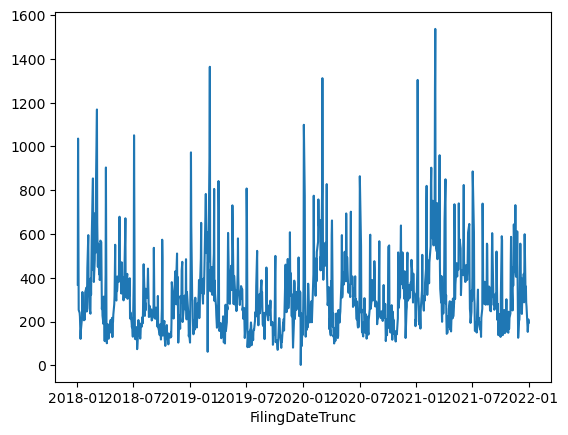

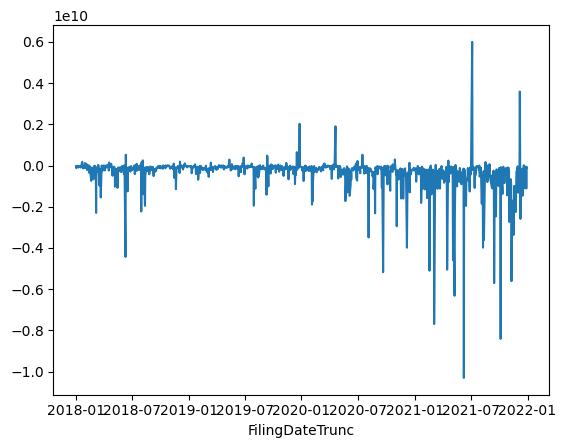

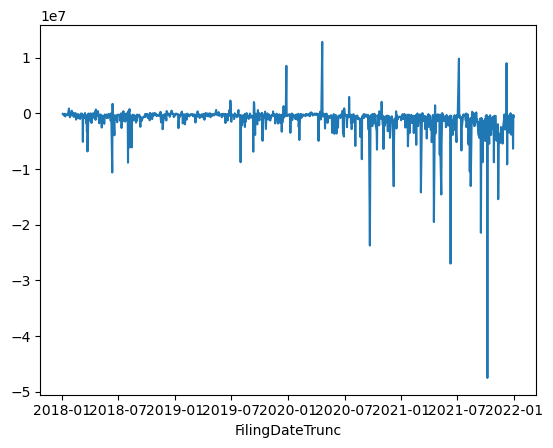

(array([37831., 26280., 33002., 29427., 24294., 38838., 28814., 41552.,
        37635., 31582.]),
 array([17533. , 17678.8, 17824.6, 17970.4, 18116.2, 18262. , 18407.8,
        18553.6, 18699.4, 18845.2, 18991. ]),
 <BarContainer object of 10 artists>)

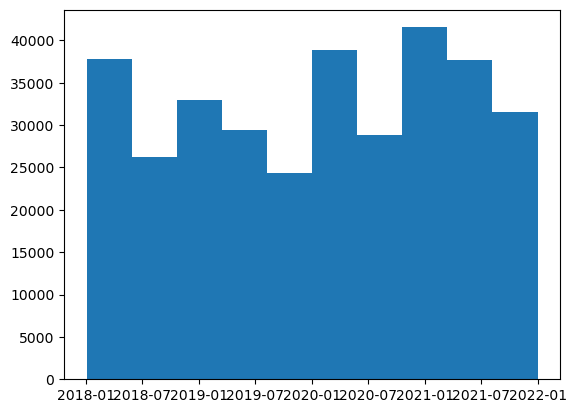

In [36]:
all_insider_trades = companies[0].insider_data_df.head(0)
from tqdm import tqdm
#for j in tqdm(range(len(companies[:200]))):
for j in tqdm(range(len(companies))):
    all_insider_trades = pd.concat([all_insider_trades, companies[j].insider_data_df])#  @ gunnar very nice asymptotic runtime
    
all_insider_trades['FilingDateTrunc'] = all_insider_trades['FilingDate'].dt.date
all_insider_trades.groupby('FilingDateTrunc')['FilingDate'].count().plot()
plt.show()
all_insider_trades.to_csv('AllTradesForExcelGSK.csv')

all_insider_trades.groupby('FilingDateTrunc')['Value'].sum().plot()
plt.show()
all_insider_trades.groupby('FilingDateTrunc')['Value'].mean().plot()
plt.show()
plt.hist(all_insider_trades['FilingDateTrunc'])